## **ADS CREATION V10.4**
v10.4.0 - Removed other event from the data-set, identified 4 major outages and removed them for outages, also used IQR method to remove outliers: <br>
- Used IQR range 0.1 to 0.99 and removed data-set based on these ranges

v10.3.0 - Adding no of outages based on CLUE, CAUSE, OCCURN: <br>
- 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY' <br>
- Categorized outages based on dispatch area location '34th', 'ARL.', 'MILL', 'ENGLISH', 'W.I.', 'SOUTH' and 'NO_LOCATION' based on minimum distance from outage <br>

v10.2.0 - Adding priority/queueing feature into the analytical dataset based on : <br>
- Rank based on simple customer quantity as mentioned by Business (live rankings to be followed, numerical feature) <br>
- Rank based on the factor of distance from centroid and customer quantity (live rankings to be followed, approach #2, numerical feature) <br>

In [2]:
import csv
import math
import time
import warnings
import operator
import statistics
import seaborn as sns
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import datetime
from scipy import stats
from IPython.display import display_html
from multiprocessing import Pool
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

## **FILTERING FAC_JOB TABLE**

In [3]:
%%time
df_facility_job_his = pd.read_csv('gs://aes-datahub-0001-raw/OMS/2002-2020/IPL/HIS_FACILITY_JOB_IPL.csv', sep = ",", encoding = "ISO-8859-1")

CPU times: user 13.7 s, sys: 2.84 s, total: 16.6 s
Wall time: 28 s


In [3]:
# changing the date format

df_facility_job_his["CREATION_DATETIME"] = pd.to_datetime(df_facility_job_his["CREATION_DATETIME"], errors ='coerce')
df_facility_job_his["ENERGIZED_DATETIME"] = pd.to_datetime(df_facility_job_his["ENERGIZED_DATETIME"], errors ='coerce')
df_facility_job_his["ETR_DATETIME"] = pd.to_datetime(df_facility_job_his["ETR_DATETIME"], errors ='coerce')

# creating blue sky flags

df_facility_job_his['BLUE_SKY_FLG'] = ( (df_facility_job_his.TOT_LOSS_POWER_FLG == 'T') & 
                                           ((df_facility_job_his.MAJ_OTG_ID == 0) | (df_facility_job_his.MAJ_OTG_ID.isnull())) &
                                           ((df_facility_job_his.ISOLATED_TO_CUST_FLG == 'F') | (df_facility_job_his.ISOLATED_TO_CUST_FLG.isnull())) &
                                           ((df_facility_job_his.ROUTINE_FLG == 'F') | (df_facility_job_his.ROUTINE_FLG.isnull())) &
                                           ((df_facility_job_his.ENERGIZED_DATETIME - 
                                             df_facility_job_his.CREATION_DATETIME).dt.total_seconds().div(60).round(2) > 5) 
                                          & (df_facility_job_his.CREATION_DATETIME.dt.year > 2002) & (df_facility_job_his.CREATION_DATETIME.dt.year < 2020))
print("Total blue sky Events: ", len(df_facility_job_his[df_facility_job_his.BLUE_SKY_FLG == True]))

# creating storm event flags

df_facility_job_his['STORM_EVENT_FLG'] = ( (df_facility_job_his.TOT_LOSS_POWER_FLG == 'T') & 
                                           ((df_facility_job_his.MAJ_OTG_ID != 0) & (df_facility_job_his.MAJ_OTG_ID.notnull())) &
                                           ((df_facility_job_his.ISOLATED_TO_CUST_FLG == 'F') | (df_facility_job_his.ISOLATED_TO_CUST_FLG.isnull())) &
                                           ((df_facility_job_his.ROUTINE_FLG == 'F') | (df_facility_job_his.ROUTINE_FLG.isnull())) &
                                           ((df_facility_job_his.ENERGIZED_DATETIME -
                                             df_facility_job_his.CREATION_DATETIME).dt.total_seconds().div(60).round(2) > 5) 
                                          & (df_facility_job_his.CREATION_DATETIME.dt.year > 2002) & (df_facility_job_his.CREATION_DATETIME.dt.year < 2020))
print("Total Storm Events: ", len(df_facility_job_his[df_facility_job_his.STORM_EVENT_FLG == True]))


# filtering data

occur_remov = [30003001, 33003301, 33003302, 34003400, 34003401, 34003402, 34003403, 34003404, 34003405, 34003406, 34003407, 34003408, 34003409, 35003500,
                35003501, 35003502, 35003503, 35003504, 35003505, 35003506, 35003507, 35003508, 36003600, 36003601, 36003602, 36003603, 36003604, 36003605,
                36003606, 36003607, 36003608, 37003703, 38003802, 38003803, 38003804, 38003807, 39003910, 41004100, 41004101, 41004102, 48004800, 48004802,
                48004803, 49004900, 49004901, 49004902, 50005000, 50005001, 50005002, 52005200, 52005201, 52005202, 52005203, 52005204, 52005205, 52005206,
                52005207, 53005300, 53005301, 53005302, 53005303, 53005304, 53005305, 53005306, 53005307, 53005308, 53005309, 53005310, 54005400, 54005401,
                54005402, 54005403, 54005404, 54005405, 34003410, 30003000, 36503650, 36503651, 36503652, 36503653, 36503654, 36503655, 36503656, 36503657,
                36503658]

init_rows = len(df_facility_job_his)
init_blue_sky = len(df_facility_job_his[df_facility_job_his.BLUE_SKY_FLG == True])
init_storm = len(df_facility_job_his[df_facility_job_his.STORM_EVENT_FLG == True])
init_incident = df_facility_job_his.INCIDENT_ID.nunique()
_incident_ = len(df_facility_job_his[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("Initial Rows", init_rows)
print("Initial blue sky events", init_blue_sky)
print("Initial Storm events", init_storm)
print("Number of incident id", init_incident)
print("Unique incident-structure no",_incident_)

print("-------------After Filtering Creation_datetime from 2007 to 2019---------------------")
df_facility_job_his = df_facility_job_his[(df_facility_job_his.CREATION_DATETIME.dt.year > 2006) & (df_facility_job_his.CREATION_DATETIME.dt.year < 2020)]
_incident_ = len(df_facility_job_his[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("Rows", len(df_facility_job_his))
print("blue sky events", len(df_facility_job_his[df_facility_job_his.BLUE_SKY_FLG == True]))
print("Storm events", len(df_facility_job_his[df_facility_job_his.STORM_EVENT_FLG == True]))
print("Number of incident id", df_facility_job_his.INCIDENT_ID.nunique())
print("Unique structure no",_incident_)

print("-------------After removing CUST_QTY and DOWNSTREAM_CUST_QTY>0----------------------")
df_fac_f1 = df_facility_job_his[(df_facility_job_his.CUST_QTY > 0) & (df_facility_job_his.DOWNSTREAM_CUST_QTY > 0)]
_incident_ = len(df_fac_f1[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("Rows", len(df_fac_f1))
print("blue sky events", len(df_fac_f1[df_fac_f1.BLUE_SKY_FLG == True]))
print("Storm events", len(df_fac_f1[df_fac_f1.STORM_EVENT_FLG == True]))
print("Number of incident id", df_fac_f1.INCIDENT_ID.nunique())
print("Unique structure no",_incident_)

print("-------------After removing Equip_stn_No as <NCC> and null----------------------")
df_fac_f2 = df_fac_f1[(df_fac_f1.EQUIP_STN_NO != '<NCC>')]
df_fac_f2 = df_fac_f2[~df_fac_f2.EQUIP_STN_NO.isnull()]
_incident_ = len(df_fac_f2[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("Rows", len(df_fac_f2))
print("blue sky events", len(df_fac_f2[df_fac_f2.BLUE_SKY_FLG == True]))
print("Storm events", len(df_fac_f2[df_fac_f2.STORM_EVENT_FLG == True]))
print("Number of incident id", df_fac_f2.INCIDENT_ID.nunique())
print("Unique structure no",_incident_)

print("-------------After removing Occurence code starting with Cancel, Found OK and duplicate ----------------------")
df_fac_f3 = df_fac_f2[(df_fac_f2.OCCURN_DESC.str.find("CANCEL") == -1)]
df_fac_f3 = df_fac_f3[(df_fac_f3.OCCURN_DESC.str.find("FOUND OK") == -1)]
_incident_ = len(df_fac_f3[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("Rows", len(df_fac_f3))
print("blue sky events", len(df_fac_f3[df_fac_f3.BLUE_SKY_FLG == True]))
print("Storm events", len(df_fac_f3[df_fac_f3.STORM_EVENT_FLG == True]))
print("Number of incident id", df_fac_f3.INCIDENT_ID.nunique())
print("Unique structure no",_incident_)

print("-------------After removing NaN from DNI, Circuit ID 0 and NaN  from Structure Nos.----------------------")
df_fac_f4 = df_fac_f3[(df_fac_f3.CIRCT_ID != 0)]
df_fac_f4 = df_fac_f4[~df_fac_f4.CIRCT_ID.isnull()]
df_fac_f4 = df_fac_f4[~df_fac_f4.STRCTUR_NO.isnull()]
df_fac_f4 = df_fac_f4[~df_fac_f4.DNI_EQUIP_TYPE.isnull()]
_incident_ = len(df_fac_f4[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("Rows", len(df_fac_f4))
print("blue sky events", len(df_fac_f4[df_fac_f4.BLUE_SKY_FLG == True]))
print("Storm events", len(df_fac_f4[df_fac_f4.STORM_EVENT_FLG == True]))
print("Number of incident id", df_fac_f4.INCIDENT_ID.nunique())
print("Unique structure no",_incident_)

print("-------------After removing NaN Energized datetime ----------------------")
df_fac_f5 = df_fac_f4[~(df_fac_f4.ENERGIZED_DATETIME.isnull())]
_incident_ = len(df_fac_f5[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("Rows", len(df_fac_f5))
print("blue sky events", len(df_fac_f5[df_fac_f5.BLUE_SKY_FLG == True]))
print("Storm events", len(df_fac_f5[df_fac_f5.STORM_EVENT_FLG == True]))
print("Number of incident id", df_fac_f5.INCIDENT_ID.nunique())
print("Unique structure no",_incident_)

print("-------------After removing Energized datetime < CREATION_DATETIME----------------------")
df_fac_f6 = df_fac_f5[df_fac_f5.ENERGIZED_DATETIME > df_fac_f5.CREATION_DATETIME]
_incident_ = len(df_fac_f6[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("Rows", len(df_fac_f6))
print("blue sky events", len(df_fac_f6[df_fac_f6.BLUE_SKY_FLG == True]))
print("Storm events", len(df_fac_f6[df_fac_f6.STORM_EVENT_FLG == True]))
print("Number of incident id", df_fac_f6.INCIDENT_ID.nunique())
print("Unique structure no",_incident_)
                       
print("-------------After removing CLUE_CD not starting with zero----------------------")
df_fac_f7 = df_fac_f6[(df_fac_f6.CLUE_CD.str[:1] == '0') & (df_fac_f6.CLUE_CD.str[:2] != '00')]
df_fac_f7 = df_fac_f7[df_fac_f7.CLUE_CD != '01']
_incident_ = len(df_fac_f7[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("Rows", len(df_fac_f7))
print("blue sky events", len(df_fac_f7[df_fac_f7.BLUE_SKY_FLG == True]))
print("Storm events", len(df_fac_f7[df_fac_f7.STORM_EVENT_FLG == True]))
print("Number of incident id", df_fac_f7.INCIDENT_ID.nunique())
print("Unique structure no",_incident_)

print("-------------After removing Occurence code starting with Cancel, Found OK and duplicate ----------------------")
df_fac_f8 = df_fac_f7[~(df_fac_f7.OCCURN_CD.isin(occur_remov))]
_incident_ = len(df_fac_f8[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("Rows", len(df_fac_f8))
print("blue sky events", len(df_fac_f8[df_fac_f8.BLUE_SKY_FLG == True]))
print("Storm events", len(df_fac_f8[df_fac_f8.STORM_EVENT_FLG == True]))
print("Number of incident id", df_fac_f8.INCIDENT_ID.nunique())
print("Unique structure no",_incident_)

# Incident_id to be removed 1750 cases

exclude_inc_ = pd.read_csv(r'gs://aes-datahub-0002-curated/Outage_Restoration/Test/EXCLUDE_INC.csv', header=None)[1]

df_fac_final = df_fac_f8[~(df_fac_f8.INCIDENT_ID.isin(exclude_inc_))]

#Changing Flags to 0 and 1 
df_fac_final.BLUE_SKY_FLG = df_fac_final.BLUE_SKY_FLG.apply(lambda x: 1 if x==True else 0) 
df_fac_final.STORM_EVENT_FLG = df_fac_final.STORM_EVENT_FLG.apply(lambda x: 1 if x==True else 0) 

del df_facility_job_his, df_fac_f1, df_fac_f2, df_fac_f3, df_fac_f4, df_fac_f5, df_fac_f6, df_fac_f7

Total blue sky Events:  133836
Total Storm Events:  38384
Initial Rows 1268993
Initial blue sky events 133836
Initial Storm events 38384
Number of incident id 914650
Unique incident-structure no 1021773
-------------After Filtering Creation_datetime from 2007 to 2019---------------------
Rows 937870
blue sky events 107094
Storm events 33036
Number of incident id 832388
Unique structure no 872966
-------------After removing CUST_QTY and DOWNSTREAM_CUST_QTY>0----------------------
Rows 627436
blue sky events 96564
Storm events 32789
Number of incident id 540420
Unique structure no 577570
-------------After removing Equip_stn_No as <NCC> and null----------------------
Rows 610810
blue sky events 96262
Storm events 32730
Number of incident id 533462
Unique structure no 570331
-------------After removing Occurence code starting with Cancel, Found OK and duplicate ----------------------
Rows 418252
blue sky events 96213
Storm events 32676
Number of incident id 372606
Unique structure no 3883

In [4]:
print("Rows", len(df_fac_final))
_incident_ = len(df_fac_final[['INCIDENT_ID','STRCTUR_NO']].drop_duplicates())
print("blue sky events", len(df_fac_final[df_fac_final.BLUE_SKY_FLG == 1]))
print("Storm events", len(df_fac_final[df_fac_final.STORM_EVENT_FLG == 1]))
print("Number of incident id", df_fac_final.INCIDENT_ID.nunique())
print("Unique structure no",_incident_)

Rows 132917
blue sky events 75443
Storm events 27680
Number of incident id 101519
Unique structure no 111568


In [5]:
df_maj_otg_df = df_fac_final[(~df_fac_final.MAJ_OTG_ID.isnull()) & (df_fac_final.MAJ_OTG_ID != 0)]
maj_otg_df = df_maj_otg_df.groupby(['INCIDENT_ID', 'STRCTUR_NO'], as_index = False).agg({'MAJ_OTG_ID' : pd.Series.unique})
inc_ = maj_otg_df[maj_otg_df.MAJ_OTG_ID>1].INCIDENT_ID

In [6]:
x = df_fac_final[df_fac_final.INCIDENT_ID.isin(inc_)]

In [7]:
maj_otg_df = df_maj_otg_df.groupby(['INCIDENT_ID', 'STRCTUR_NO'], as_index = False).agg({'MAJ_OTG_ID' : 'max'})

In [8]:
df_event_flg = pd.read_csv("gs://aes-datahub-0001-curated/Outage_Restoration/Historical_Data/Archived/Event_flag.csv", sep = ",")[['INCIDENT_ID','STRCTUR_NO','CIRCT_ID' ,'DNI_EQUIP_TYPE', 'EVENT']]
len(df_event_flg)

111163

In [9]:
df_check = df_fac_final.groupby(['INCIDENT_ID','STRCTUR_NO', 'CIRCT_ID', 'DNI_EQUIP_TYPE']).nunique()
df_check.sum()

FAC_JOB_ID              132917
MAJ_OTG_ID               93704
EQUIP_STN_NO            132817
DIST_NO                 111643
HOST_SEQ_ID                  0
PRIORITY_VAL            114471
CUST_QTY                130118
CLUE_CD                 118710
CLUE_DESC               118710
CREATION_DATETIME       111645
CALL_QTY                126282
KEY_CUST_QTY            119392
SPLIT_FAC_JOB_FLG        41720
CAUSE_CD                107431
CAUSE_DESC              107398
OCCURN_CD               111644
OCCURN_DESC             111823
CLIMATIC_CD              90246
CLIMATIC_DESC            90246
CITY_NAM                110194
LOC_DESC                108957
WRK_ORD_NUM                  0
COMMENT_TEXT             53499
CALL_ID                 132917
KVA_VAL                 127865
BOOK_NO                      0
ADDRESS                 111496
CIRCT_NAM               111643
CLUE_CD2                  1927
INSERTED_DATE           112277
DOWNSTREAM_KVA_VAL      128539
DOWNSTREAM_CUST_QTY     130118
COMPL_DA

In [10]:
df_numerical = df_fac_final.groupby(['INCIDENT_ID','STRCTUR_NO', 'CIRCT_ID', 'DNI_EQUIP_TYPE' ], as_index = False).agg({'CUST_QTY':'sum','CALL_QTY':'sum','KEY_CUST_QTY':'sum','DOWNSTREAM_CUST_QTY':'sum','KVA_VAL':'mean',
                                       'DOWNSTREAM_KVA_VAL':'mean', 'FAC_JOB_ID': 'max', 'ETR_DATETIME': 'max', 'CREATION_DATETIME': 'min', 'MAJ_OTG_ID' : 'sum',
                                      'ENERGIZED_DATETIME': 'max', 'SUBST_ID': 'min'})

In [11]:
df_numerical = pd.merge(df_event_flg, df_numerical, on = ['INCIDENT_ID','STRCTUR_NO', 'CIRCT_ID', 'DNI_EQUIP_TYPE' ])

In [12]:
print(df_numerical.shape)

(111082, 17)


## **Adding extra columns like Day Night flag and creating dependent variable TTR column**

In [13]:
# creating day night flag for outages

df_numerical['DAY_FLAG'] = df_numerical.CREATION_DATETIME.dt.hour.apply(lambda x: 1 if ((x >= 6) & (x<18)) else 0)
df_numerical['TTR'] = (df_numerical.ENERGIZED_DATETIME - df_numerical.CREATION_DATETIME).dt.total_seconds().div(60).round(4)

In [14]:
print(df_numerical.shape)

(111082, 19)


## **CLUE CODE CLEAN**

In [15]:
df_fac_final.PRIORITY_VAL = df_fac_final.PRIORITY_VAL.astype(float)

df_fac_final['PRIORITY_VAL_1.0'] = df_fac_final['PRIORITY_VAL'].apply(lambda x: 1 if x == 1 else 0)
df_fac_final['PRIORITY_VAL_2.0'] = df_fac_final['PRIORITY_VAL'].apply(lambda x: 1 if x == 2 else 0)
df_fac_final['PRIORITY_VAL_3.0'] = df_fac_final['PRIORITY_VAL'].apply(lambda x: 1 if x == 3 else 0)
df_fac_final['PRIORITY_VAL_5.0'] = df_fac_final['PRIORITY_VAL'].apply(lambda x: 1 if x == 5 else 0)

df_fac_final.drop(['PRIORITY_VAL'],axis=1,inplace=True)

df_fac_final.CITY_NAM = df_fac_final.CITY_NAM.apply(lambda x: 'INDIANAPOLIS' if(str(x).find('INDIAN') != -1) else x)
df_fac_final.CITY_NAM = df_fac_final.CITY_NAM.apply(lambda x: 'NO_CITY' if(x != x) else x)

In [16]:
# segregation of clue code desc

df_fac_final['POLE_CLUE_FLG'] = df_fac_final.CLUE_DESC.apply(lambda x: 1 if (x.lower().find('pole') != -1) else 0)
df_fac_final['PART_LIGHT_CLUE_FLG'] = df_fac_final.CLUE_DESC.apply(lambda x: 1 if (x.lower().find('part lights') != -1) else 0)
df_fac_final['EMERGENCY_CLUE_FLG'] = df_fac_final.CLUE_DESC.apply(lambda x: 1 if (x.lower().find('emergency') != -1) else 0)
df_fac_final['POWER_OUT_CLUE_FLG'] = df_fac_final.CLUE_DESC.apply(lambda x: 1 if (x.lower().find('power out') != -1) else 0)
df_fac_final['TREE_CLUE_FLG'] = df_fac_final.CLUE_DESC.apply(lambda x: 1 if (x.lower().find('tree') != -1) else 0)
df_fac_final['WIRE_DOWN_CLUE_FLG'] = df_fac_final.CLUE_DESC.apply(lambda x: 1 if (x.lower().find('wire down') != -1) else 0)
df_fac_final['IVR_CLUE_FLG'] = df_fac_final.CLUE_DESC.apply(lambda x: 1 if (x.lower().find('ivr') != -1) else 0)
df_fac_final['EQUIPMENT_CLUE_FLG'] = df_fac_final.CLUE_DESC.apply(lambda x: 1 if (x.find('EQUIPMENT') != -1) else 0)
df_fac_final['TRANSFORMER_CLUE_FLG'] = df_fac_final.CLUE_DESC.apply(lambda x: 1 if (x.find('TRANSFORMER') != -1) else 0)
df_fac_final['OPEN_DEVICE_CLUE_FLG'] = df_fac_final.CLUE_DESC.apply(lambda x: 1 if (x.find('OPEN DEVICE') != -1) else 0)


#segration of cause desc
df_fac_final['CAUSE_DESC1'] = df_fac_final[['CAUSE_DESC']].fillna('0')
df_fac_final['OH_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if((x.find('OH') != -1) | (x.find('O.H.') != -1)) else 0)
df_fac_final['UG_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if((x.find('UG') != -1) | (x.find('U.G.') != -1)) else 0)
df_fac_final['ANIMAL_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('ANIMAL') != -1) else 0)
df_fac_final['WEATHER_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('WEATHER') != -1) else 0)
df_fac_final['WEATHER_COLD_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('COLD') != -1) else 0)
df_fac_final['WEATHER_LIGHTNING_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('LIGHTNING') != -1) else 0)
df_fac_final['WEATHER__SNOW_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('SNOW') != -1) else 0)
df_fac_final['WEATHER__WIND_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('WIND') != -1) else 0)
df_fac_final['WEATHER__HEAT_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('HEAT') != -1) else 0)
df_fac_final['WEATHER__FLOOD_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('FLOOD') != -1) else 0)
df_fac_final['PUBLIC_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('PUBLIC') != -1) else 0)
df_fac_final['STREET_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('ST ') != -1) else 0)
df_fac_final['SUBSTATION_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('SUBSTATION') != -1) else 0)
df_fac_final['TREE_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('TREE') != -1) else 0)
df_fac_final['MISCELLANEOUS_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('MISCELLANEOUS') != -1) else 0)
df_fac_final['CUST_REQUEST_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('CUSTOMER REQUEST') != -1) else 0)
df_fac_final['NO_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('NO CAUSE') != -1) else 0)
df_fac_final['PLANNED_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('PLANNED WORK') != -1) else 0)
df_fac_final['NO_OUTAGE_CAUSE_FLG'] = df_fac_final.CAUSE_DESC1.apply(lambda x: 1 if(x.find('NO OUTAGE') != -1) else 0)


#segration of OCCURN desc
df_fac_final['FUSE_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if((x.find('FUSE') != -1) & (x.find('FUSE NOT') == -1)) else 0)
df_fac_final['CUST_EQUIP_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('CUSTOMER EQUIP') != -1) else 0)
df_fac_final['POLE_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('POLE') != -1) else 0)
df_fac_final['TRANSFORMER_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('TRANSFORMER') != -1) else 0)
df_fac_final['METER_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('METER') != -1) else 0)
df_fac_final['SERVICE_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('SERVICE') != -1) else 0)
df_fac_final['CABLE_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('CABLE') != -1) else 0)
df_fac_final['ST_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('ST') != -1) else 0)
df_fac_final['FIRE_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('FIRE') != -1) else 0)
df_fac_final['FOUND_OPEN_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if((x.find('FOUND OPEN') != -1) & (x.find('NOT FOUND OPEN') == -1)) else 0)
df_fac_final['PUBLIC_SAFETY_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('SAFETY') != -1) else 0)
df_fac_final['WIRE_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('WIRE') != -1) else 0)
df_fac_final['SWITCH_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('SWITCH') != -1) else 0)
df_fac_final['CUTOUT_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('CUTOUT') != -1) else 0)
df_fac_final['REGULATOR_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('REGULATOR') != -1) else 0)
df_fac_final['CAP_BANK_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('CAP BANK') != -1) else 0)
df_fac_final['OH_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('OH') != -1) else 0)
df_fac_final['RECLOSER_OCCURN_FLG'] = df_fac_final.OCCURN_DESC.apply(lambda x: 1 if(x.find('RECLOSER') != -1) else 0)

df_fac_final = df_fac_final.drop(columns = ['CAUSE_DESC1'])

In [17]:
df_fac_cat = df_fac_final.groupby(['INCIDENT_ID','STRCTUR_NO', 'CIRCT_ID', 'DNI_EQUIP_TYPE'], as_index = False).agg({'POLE_CLUE_FLG': 'sum', 'PART_LIGHT_CLUE_FLG': 'sum',
                                                                          'EMERGENCY_CLUE_FLG': 'sum','POWER_OUT_CLUE_FLG': 'sum',
                                                                          'TREE_CLUE_FLG': 'sum', 'WIRE_DOWN_CLUE_FLG': 'sum',
                                                                          'OPEN_DEVICE_CLUE_FLG':'sum', 'EQUIPMENT_CLUE_FLG': 'sum',
                                                                          'TRANSFORMER_CLUE_FLG':'sum','IVR_CLUE_FLG': 'sum',
                                                                          'OH_CAUSE_FLG': 'sum', 'UG_CAUSE_FLG': 'sum', 
                                                                          'ANIMAL_CAUSE_FLG': 'sum','WEATHER_CAUSE_FLG': 'sum', 
                                                                          'WEATHER_COLD_CAUSE_FLG': 'sum','PUBLIC_CAUSE_FLG': 'sum',
                                                                         'WEATHER_LIGHTNING_CAUSE_FLG': 'sum', 'WEATHER__SNOW_CAUSE_FLG': 'sum',
                                                                          'WEATHER__WIND_CAUSE_FLG': 'sum','WEATHER__HEAT_CAUSE_FLG': 'sum',
                                                                         'WEATHER__FLOOD_CAUSE_FLG': 'sum', 'STREET_CAUSE_FLG': 'sum',
                                                                        'MISCELLANEOUS_CAUSE_FLG':'sum', 'CUST_REQUEST_CAUSE_FLG': 'sum',
                                                                          'SUBSTATION_CAUSE_FLG': 'sum','TREE_CAUSE_FLG': 'sum',
                                                                          'NO_CAUSE_FLG': 'sum', 'PLANNED_CAUSE_FLG': 'sum',
                                                                          'NO_OUTAGE_CAUSE_FLG': 'sum',
                                                                          'PRIORITY_VAL_1.0' : 'sum', 'PRIORITY_VAL_2.0': 'sum', 
                                                                          'PRIORITY_VAL_3.0': 'sum', 'PRIORITY_VAL_5.0': 'sum',
                                                                          'FUSE_OCCURN_FLG': 'sum', 'CUST_EQUIP_OCCURN_FLG': 'sum',
                                                                          'POLE_OCCURN_FLG': 'sum', 'TRANSFORMER_OCCURN_FLG': 'sum', 
                                                                          'METER_OCCURN_FLG': 'sum', 'SERVICE_OCCURN_FLG': 'sum',
                                                                          'CABLE_OCCURN_FLG': 'sum', 'ST_OCCURN_FLG': 'sum',
                                                                          'FIRE_OCCURN_FLG': 'sum', 'FOUND_OPEN_OCCURN_FLG': 'sum',
                                                                          'PUBLIC_SAFETY_OCCURN_FLG': 'sum', 'WIRE_OCCURN_FLG': 'sum',
                                                                          'SWITCH_OCCURN_FLG': 'sum', 'REGULATOR_OCCURN_FLG': 'sum',
                                                                          'CUTOUT_OCCURN_FLG': 'sum','CAP_BANK_OCCURN_FLG': 'sum',
                                                                          'RECLOSER_OCCURN_FLG': 'sum','OH_OCCURN_FLG': 'sum'
                                                                          })
dummy_col = ['POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG','POWER_OUT_CLUE_FLG','OPEN_DEVICE_CLUE_FLG',
                'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG','IVR_CLUE_FLG','EQUIPMENT_CLUE_FLG','TRANSFORMER_CLUE_FLG',
             'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG','WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG',
             'PUBLIC_CAUSE_FLG','WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG','WEATHER__WIND_CAUSE_FLG',
             'WEATHER__HEAT_CAUSE_FLG','CUST_REQUEST_CAUSE_FLG','WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG',
             'SUBSTATION_CAUSE_FLG','TREE_CAUSE_FLG','MISCELLANEOUS_CAUSE_FLG','NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 
             'NO_OUTAGE_CAUSE_FLG',
             'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 
             'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG','CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
             'FOUND_OPEN_OCCURN_FLG','PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG',
             'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG','CAP_BANK_OCCURN_FLG','RECLOSER_OCCURN_FLG','OH_OCCURN_FLG',
             'PRIORITY_VAL_1.0','PRIORITY_VAL_2.0','PRIORITY_VAL_3.0','PRIORITY_VAL_5.0']
for i in dummy_col:
    df_fac_cat[i] =  df_fac_cat[i].apply(lambda x: 1 if x>=1 else 0)

df_fac_cat = df_fac_cat[['INCIDENT_ID','STRCTUR_NO','CIRCT_ID', 'DNI_EQUIP_TYPE',
                         'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG','POWER_OUT_CLUE_FLG','OPEN_DEVICE_CLUE_FLG',
                'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG','IVR_CLUE_FLG','EQUIPMENT_CLUE_FLG','TRANSFORMER_CLUE_FLG',
             'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG','WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG',
             'PUBLIC_CAUSE_FLG','WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG','WEATHER__WIND_CAUSE_FLG',
             'WEATHER__HEAT_CAUSE_FLG','CUST_REQUEST_CAUSE_FLG','WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG',
             'SUBSTATION_CAUSE_FLG','TREE_CAUSE_FLG','MISCELLANEOUS_CAUSE_FLG','NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 
              'NO_OUTAGE_CAUSE_FLG',
             'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 
             'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG','CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
             'FOUND_OPEN_OCCURN_FLG','PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG',
             'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG','CAP_BANK_OCCURN_FLG','RECLOSER_OCCURN_FLG','OH_OCCURN_FLG',
             'PRIORITY_VAL_1.0','PRIORITY_VAL_2.0','PRIORITY_VAL_3.0','PRIORITY_VAL_5.0']].drop_duplicates()

QC check if the list retains to 111163

In [18]:
print(df_fac_cat.shape)

(111643, 55)


## **CAUSE and OCCURN DESC CLEANING**

In [19]:
df_fac_final['OCCURN_DESC'] = df_fac_final['OCCURN_DESC'].str.replace(";","")

In [20]:
t = df_fac_final.groupby(['INCIDENT_ID','STRCTUR_NO', 'CIRCT_ID', 'DNI_EQUIP_TYPE'], as_index = False).agg({'OCCURN_DESC': pd.Series.nunique,'CAUSE_DESC': pd.Series.nunique})

In [21]:
t[t.OCCURN_DESC > 1] , t[t.CAUSE_DESC > 1]

(        INCIDENT_ID STRCTUR_NO  CIRCT_ID DNI_EQUIP_TYPE  OCCURN_DESC  CAUSE_DESC
 59012 2000853164.00   615-A/75   1707.00          2TBOD            2           1,
         INCIDENT_ID STRCTUR_NO  CIRCT_ID DNI_EQUIP_TYPE  OCCURN_DESC  CAUSE_DESC
 35313 2000595721.00  369-A/326   2457.00          1TBOH            1           2
 86594 2001169259.00  469-B/166   5154.00           FUSE            1           2)

In [22]:
df_fac_final[df_fac_final.INCIDENT_ID == t[t.OCCURN_DESC > 1].INCIDENT_ID[59012]].CAD_ID

689555    IPL-102412-000184
689794                  NaN
Name: CAD_ID, dtype: object

In [23]:
# del row with CAD_ID not present

df_fac_final = df_fac_final.drop(689794)

In [24]:
df_fac_final[df_fac_final.INCIDENT_ID.isin(t[t.CAUSE_DESC > 1].INCIDENT_ID)]

,FAC_JOB_ID,CIRCT_ID,MAJ_OTG_ID,EQUIP_STN_NO,DIST_NO,HOST_SEQ_ID,CUST_QTY,CLUE_CD,CLUE_DESC,CREATION_DATETIME,CALL_QTY,KEY_CUST_QTY,SPLIT_FAC_JOB_FLG,CAUSE_CD,CAUSE_DESC,OCCURN_CD,OCCURN_DESC,CLIMATIC_CD,CLIMATIC_DESC,CITY_NAM,LOC_DESC,WRK_ORD_NUM,COMMENT_TEXT,CALL_ID,KVA_VAL,BOOK_NO,ADDRESS,CIRCT_NAM,CLUE_CD2,INSERTED_DATE,DOWNSTREAM_KVA_VAL,DOWNSTREAM_CUST_QTY,COMPL_DATETIME,TOT_LOSS_POWER_FLG,ISOLATED_TO_CUST_FLG,PLANNED_OUTAGE_FLG,ROUTINE_FLG,DNI_EQUIP_TYPE,SUBST_ID,WORK_ORD_1_NO,WORK_ORD_2_NO,WORK_ORD_3_NO,WORK_ORD_4_NO,WORK_ORD_5_NO,ENERGIZED_DATETIME,DISPLAY_TEXT,POLICE_OPERATOR_ID,POLICE_INC_NO,FIRE_OPERATOR_ID,FIRE_INC_NO,CAD_ID,STRCTUR_NO,FAC_JOB_PARENT_ID,MAJ_INCIDENT_FLG,MAJ_INCIDENT_CAUSE,ZONE_DESC,DIST_DESC,ZONE_ID,GEO_DIST_NO,ETR_DATETIME,SUBST_SHUTDOWN_FLG,HIS_FAC_JOB_COMMENT,CIRCT_DESC,SUBST_DESC,DCNID_VAL,CREW_REMARKS,INCIDENT_ID,CLUE_DESC2,DIST_ABBREV,BLUE_SKY_FLG,STORM_EVENT_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,PUBLIC_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,CUTOUT_OCCURN_FLG,REGULATOR_OCCURN_FLG,CAP_BANK_OCCURN_FLG,OH_OCCURN_FLG,RECLOSER_OCCURN_FLG
477581,2001573885,2457.00,0.00,1742831B_B,1.00,nan,1.00,09IV,DO NOT USE - IVR\POWER OUT,2009-08-07 11:42:57,1,0.00,NaN,14001409.00,PUBLIC\FIRE,21002108.00,SERVICE\SERVICE WIRE SHORT,N,Normal - Clear,INDIANAPOLIS,** 5014 HILLSIDE AVE 2200E/N,nan,cust said everyone else came back on but her ;...,2026692708,0.00,nan,5014 HILLSIDE AVE 2200E/N,CRESTVIEW NO. 7,NaN,2009-08-07 14:52:06,0.00,1.00,2009-08-07 13:53:03,F,T,F,F,1TBOH,245.00,NaN,NaN,NaN,nan,nan,2009-08-07 13:53:03,369-A/326,nan,nan,nan,nan,IPL-080709-000205,369-A/326,nan,F,PUBLIC\FIRE,IPL,IPL,1.00,nan,2009-08-07 15:12:57,NaN,NaN,CRESTVIEW NO. 7,CRESTVIEW,nan,NaN,2000595721.00,NaN,NaN,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
477582,2001573964,2457.00,0.00,1742831B_B,1.00,nan,4.00,09OD,DO NOT USE - SYSTEM\OPEN DEVICE,2009-08-07 11:42:57,1,0.00,NaN,12001201.00,TREE\ON SECONDARY,21002108.00,SERVICE\SERVICE WIRE SHORT,NaN,NaN,INDIANAPOLIS,No Address : Loc 2000655770,nan,LOCATION CREATED BY OPENING DEVICE: 369-A/326 ...,2026692944,25.00,nan,NaN,CRESTVIEW NO. 7,NaN,2009-08-07 14:52:06,25.00,4.00,2009-08-07 14:51:49,F,T,F,F,1TBOH,245.00,NaN,NaN,NaN,nan,nan,2009-08-07 13:53:03,369-A/326,nan,nan,nan,nan,NaN,369-A/326,nan,F,PUBLIC\FIRE,IPL,IPL,1.00,nan,2009-08-07 15:12:57,NaN,NaN,CRESTVIEW NO. 7,CRESTVIEW,nan,NaN,2000595721.00,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
966712,2002277141,5154.00,nan,1777021_A,1.00,nan,4.00,09GC,ACG GROUPABLE CLUE CODE,2016-09-02 09:47:24,1,0.00,F,33003301.00,PUBLIC\VEHICLE ACCIDENT,31003100.00,"FUSE\OPEN, FUSE BLOWN",NaN,NaN,NO_CITY,W/HILLSIDE AT LANGLY,nan,NaN,2030607709,0.00,nan,W/HILLSIDE AT LANGLY,ROOSEVELT,NaN,2016-09-05 11:49:07,100.00,4.00,NaN,T,NaN,NaN,NaN,FUSE,33.00,NaN,NaN,NaN,nan,nan,2016-09-02 10:41:49,469-B/166,nan,nan,nan,nan,NaN,469-B/166,nan,F,NaN,IPL,NaN,1.00,nan,NaT,NaN,NaN,ROOSEVELT,MASSACHUSETTS,nan,NaN,2001169259.00,NaN,NaN,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
966713,2002277142,5154.00,nan,1777021

In [25]:
#del row with CAD_ID not present
df_fac_final = df_fac_final.drop(966712)
# #completion time not present
df_fac_final = df_fac_final.drop(966713)
df_fac_final = df_fac_final.drop(477581)

### **CITY**

In [26]:
%%time

# city treatment
def cat_city_treat(group):
    if(group.CITY_NAM.nunique() > 1):
        x = group[group.CITY_NAM != 'NO_CITY'].CITY_NAM.unique()
        group.CITY_NAM = x[0]
        return group
    else:
        return group
df_treated = df_fac_final[['INCIDENT_ID','STRCTUR_NO', 'CIRCT_ID', 'DNI_EQUIP_TYPE', 'CITY_NAM']]
df_treated = df_treated.groupby(['INCIDENT_ID','STRCTUR_NO', 'CIRCT_ID', 'DNI_EQUIP_TYPE'], as_index = False).apply(cat_city_treat)

CPU times: user 1min 19s, sys: 610 ms, total: 1min 20s
Wall time: 1min 20s


In [27]:
len(df_treated[['INCIDENT_ID','STRCTUR_NO', 'CIRCT_ID', 'DNI_EQUIP_TYPE', 'CITY_NAM']].drop_duplicates())

111643

QC check complete

In [28]:
df_treated = df_treated[['INCIDENT_ID','STRCTUR_NO', 'CIRCT_ID', 'DNI_EQUIP_TYPE','CITY_NAM']].drop_duplicates()
df_fac_cat = pd.merge(df_fac_cat, df_treated, on = ['INCIDENT_ID','STRCTUR_NO','CIRCT_ID', 'DNI_EQUIP_TYPE'])

In [29]:
print(df_fac_cat.shape)

(111643, 56)


In [30]:
df_fac_cat.head()

,INCIDENT_ID,STRCTUR_NO,CIRCT_ID,DNI_EQUIP_TYPE,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM
0,2000383861.00,3059,3059.00,SSUB,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS
1,2000383864.00,494-B/403,1252.00,FUSE,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS
2,2000383866.00,404-A/85,1958.00,1TBOH,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS
3,2000383867.00,675--/125,1701.00,3TBOH,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS
4,2000383871.00,465-A/25,1960.00,1TBOH,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS


## **X Y Coordinate treatment**

In [31]:
%%time
df_his_location = pd.read_csv('gs://aes-datahub-0001-raw/OMS/2002-2020/IPL/HIS_LOCATION_IPL.csv', sep = "|")

CPU times: user 49.1 s, sys: 7.7 s, total: 56.8 s
Wall time: 1min 26s


In [32]:
df_his_location = df_his_location[['INCIDENT_ID','STRCTUR_NO','GEO_X_COORD','GEO_Y_COORD','PRIMARY_LOC_FLG']].drop_duplicates()
df_his_location = df_his_location[df_his_location.INCIDENT_ID.isin(df_fac_final.INCIDENT_ID)]
df_his_location = df_his_location[df_his_location.STRCTUR_NO.isin(df_fac_final.STRCTUR_NO)]

### **Changing X Y coordinates to LAT and LONG**

In [33]:
%%time
# function to convert geo_x, geo_y coordinate to lat, long

def change_to_loc(df):
    demnorthing = df.GEO_Y_COORD
    demeasting = df.GEO_X_COORD
    northing = float(demnorthing) * 0.3048
    easting = float(demeasting) * 0.3048
    om = (northing - 250000 + 4151863.7425) / 6367236.89768
    fo = om + (math.sin(om) * math.cos(om)) * (0.005022893948 + 0.000029370625 * math.pow(math.cos(om), 2) + 0.000000235059 * math.pow(math.cos(om), 4) + 0.000000002181 * math.pow(math.cos(om), 6))
    tf = math.sin(fo) / math.cos(fo)
    nf2 = 0.00673949677548 * math.pow(math.cos(fo), 2)
    rn = 0.9999666667 * 6378137 / math.pow((1 - 0.0066943800229034 * math.pow(math.sin(fo), 2)), 0.5)
    q = (easting - 100000) / rn
    b2 = -0.5 * tf * (1 + nf2)
    b4 = -(1 / 12) * (5 + (3 * math.pow(tf, 2)) + (nf2 * (1 - 9 * math.pow(tf, 2)) - 4 * math.pow(nf2, 2)))
    b6 = (1 / 360) * (61 + (90 * math.pow(tf, 2)) + (45 * math.pow(tf, 4)) + (nf2 * (46 - (252 * math.pow(tf, 2)) - (90 * math.pow(tf, 4)))))
    lat = fo + b2 * math.pow(q, 2) * (1 + math.pow(q, 2) * (b4 + b6 * math.pow(q, 2)))
    b3 = -(1 / 6) * (1 + 2 * math.pow(tf, 2) + nf2)
    b5 = (1 / 120) * (5 + 28 * math.pow(tf, 2) + 24 * math.pow(tf, 4) + nf2 * (6 + 8 * math.pow(tf, 2)))
    b7 = -(1 / 5040) * (61 + 662 * math.pow(tf, 2) + 1320 * math.pow(tf, 4) + 720 * math.pow(tf, 6))
    l = q * (1 + math.pow(q, 2) * (b3 + math.pow(q, 2) * (b5 + b7 * math.pow(q, 2))))
    lon = 1.4951653925 - l / math.cos(fo)
    coord = [(lat * 57.2957795131), (-1 * lon * 57.2957795131)]
    return coord[0],coord[1]

df_his_location['LAT'],df_his_location['LONG'] = zip(*df_his_location.apply(change_to_loc, axis=1))

CPU times: user 3.19 s, sys: 3.71 ms, total: 3.2 s
Wall time: 3.2 s


In [34]:
(df_his_location['INCIDENT_ID'].astype(str) + df_his_location['STRCTUR_NO'].astype(str)).nunique(), len(df_his_location)

(112947, 113869)

Multiple locations were present, so had to do treating

In [35]:
%%time
def loc_treatment(group):
    group = group.reset_index(drop = True)
    if((group.LAT.nunique() > 1) | (group.LONG.nunique() > 1)):
        x = 0.0
        y = 0.0
        z = 0.0
        for i in range(len(group)):
            latitude = math.radians(float(group.LAT[i]))
            longitude = math.radians(float(group.LONG[i]))
            x += math.cos(latitude) * math.cos(longitude)
            y += math.cos(latitude) * math.sin(longitude)
            z += math.sin(latitude)
        total = len(group)
        x = x / total
        y = y / total
        z = z / total
        central_longitude = math.atan2(y, x)
        central_square_root = math.sqrt(x * x + y * y)
        central_latitude = math.atan2(z, central_square_root)
        group.LAT = math.degrees(central_latitude)
        group.LONG = math.degrees(central_longitude)
        return group
    else:
        return group

df_his_location = df_his_location.groupby(['INCIDENT_ID','STRCTUR_NO'], as_index = False).apply(loc_treatment)

CPU times: user 2min 13s, sys: 716 ms, total: 2min 14s
Wall time: 2min 14s


In [36]:
df_his_location = df_his_location[['INCIDENT_ID','STRCTUR_NO','LAT','LONG']].drop_duplicates()

In [37]:
(df_his_location['INCIDENT_ID'].astype(str) + df_his_location['STRCTUR_NO'].astype(str)).nunique(), len(df_his_location)

(112947, 112947)

In [38]:
df_his_location['LAT'] = df_his_location['LAT'].astype(float)
df_his_location['LONG'] = df_his_location['LONG'].astype(float)
df_his_location['LAT'].min(), df_his_location['LAT'].max()

(35.24263651397552, 39.98327607330718)

In [39]:
df_his_location['LONG'].min(), df_his_location['LONG'].max()

(-86.7646286032229, -85.9158985730893)

In [40]:
# function to add zone feature to the ads according to geo coordinates
def add_zone_feature(df):
    center_lat = 39.7684
    center_long = -86.1581
    zone = ''
    
    if(float(df['LAT']) < center_lat):
        if(float(df['LONG']) < center_long):
            zone = 'ZONE1'
        else:
            zone = 'ZONE2'
    else:
        if(float(df['LONG']) < center_long):
            zone = 'ZONE4'
        else:
            zone = 'ZONE3'
    
    return zone

df_his_location['ZONE'] = df_his_location.apply(add_zone_feature, axis=1)
print(df_his_location['ZONE'].unique())

['ZONE3' 'ZONE4' 'ZONE2' 'ZONE1']


In [41]:
df_fac_cat = pd.merge(df_fac_cat, df_his_location, on = ['INCIDENT_ID','STRCTUR_NO'], how = "left")

In [42]:
print(df_fac_cat.shape)
df_fac_cat.head()

(111643, 59)


,INCIDENT_ID,STRCTUR_NO,CIRCT_ID,DNI_EQUIP_TYPE,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE
0,2000383861.00,3059,3059.00,SSUB,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.88,-86.11,ZONE3
1,2000383864.00,494-B/403,1252.00,FUSE,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.78,-86.27,ZONE4
2,2000383866.00,404-A/85,1958.00,1TBOH,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.83,-86.17,ZONE4
3,2000383867.00,675--/125,1701.00,3TBOH,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.71,-86.07,ZONE2
4,2000383871.00,465-A/25,1960.00,1TBOH,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.80,-86.17,ZONE4


In [43]:
df_ads = pd.merge(df_numerical, df_fac_cat, on = ['INCIDENT_ID','STRCTUR_NO', 'CIRCT_ID', 'DNI_EQUIP_TYPE'], how = "inner")

In [44]:
print(df_fac_cat.shape)
print(df_numerical.shape)
print(df_ads.shape)
df_ads.head()

(111643, 59)
(111082, 19)
(111082, 74)


,INCIDENT_ID,STRCTUR_NO,CIRCT_ID,DNI_EQUIP_TYPE,EVENT,CUST_QTY,CALL_QTY,KEY_CUST_QTY,DOWNSTREAM_CUST_QTY,KVA_VAL,DOWNSTREAM_KVA_VAL,FAC_JOB_ID,ETR_DATETIME,CREATION_DATETIME,MAJ_OTG_ID,ENERGIZED_DATETIME,SUBST_ID,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE
0,2000383861.00,3059,3059.00,SSUB,BLUE SKY,177.00,4,1.00,177.00,592.33,592.33,2001309371,2007-01-01 05:03:00,2007-01-01 03:33:00,0.00,2007-01-01 03:48:00,305.00,0,15.00,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.88,-86.11,ZONE3
1,2000383864.00,494-B/403,1252.00,FUSE,BLUE SKY,5.00,1,0.00,5.00,433.30,433.30,2001309379,2007-01-01 11:46:14,2007-01-01 08:16:14,0.00,2007-01-01 10:04:24,125.00,1,108.17,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.78,-86.27,ZONE4
2,2000383866.00,404-A/85,1958.00,1TBOH,BLUE SKY,6.00,2,0.00,6.00,25.00,25.00,2001309376,2007-01-01 13:06:18,2007-01-01 09:36:18,0.00,2007-01-01 10:15:54,195.00,1,39.60,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.83,-86.17,ZONE4
3,2000383867.00,675--/125,1701.00,3TBOH,OTHERS,1.00,1,0.00,1.00,37.00,37.00,2001309377,2007-01-01 13:08:21,2007-01-01 09:38:00,0.00,2007-01-01 10:15:00,170.00,1,37.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.71,-86.07,ZONE2
4,2000383871.00,465-A/25,1960.00,1TBOH,OTHERS,8.00,1,0.00,8.00,25.00,25.00,2001309382,2007-01-01 14:08:10,2007-01-01 10:38:10,0.00,2007-01-01 11:11:04,195.00,1,32.90,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.80,-86.17,ZONE4


## **ADD NO OF OUTAGES FOR CLUE, CAUSE, OCCURN**

In [45]:
df_ads['CREATION_DATETIME'] = pd.to_datetime(df_ads['CREATION_DATETIME'])
df_ads['Date'] = df_ads['CREATION_DATETIME'].dt.date

df_no_of_outages = df_ads.groupby(['Date'],as_index=False).agg({'POWER_OUT_CLUE_FLG' : 'sum', 'OPEN_DEVICE_CLUE_FLG' : 'sum', 'IVR_CLUE_FLG' : 'sum', 'ANIMAL_CAUSE_FLG' : 'sum',
                                                                'WIRE_OCCURN_FLG' : 'sum'})
df_no_of_outages.rename(columns = {'POWER_OUT_CLUE_FLG' : 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'OPEN_DEVICE_CLUE_FLG' : 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
                                   'IVR_CLUE_FLG' : 'NO_OF_IVR_CLUE_PER_DAY', 'ANIMAL_CAUSE_FLG' : 'NO_OF_ANIMAL_CAUSE_PER_DAY',
                                   'WIRE_OCCURN_FLG' : 'NO_OF_WIRE_OCCURN_PER_DAY'}, inplace=True)

df_no_of_outages.head()

,Date,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY
0,2007-01-01,7,1,5,2,1
1,2007-01-02,13,4,3,2,1
2,2007-01-03,18,3,7,4,2
3,2007-01-04,20,6,5,0,3
4,2007-01-05,18,1,5,0,1


In [46]:
df_ads = df_ads[['FAC_JOB_ID','INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME', 'CIRCT_ID', 'DNI_EQUIP_TYPE', 
         'SUBST_ID', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'ETR_DATETIME', 'CUST_QTY', 'DOWNSTREAM_KVA_VAL', 
         'KVA_VAL', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 
                 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG','POWER_OUT_CLUE_FLG','OPEN_DEVICE_CLUE_FLG',
                'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG','IVR_CLUE_FLG','EQUIPMENT_CLUE_FLG','TRANSFORMER_CLUE_FLG',
             'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG','WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG',
             'PUBLIC_CAUSE_FLG','WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG','WEATHER__WIND_CAUSE_FLG',
             'WEATHER__HEAT_CAUSE_FLG','CUST_REQUEST_CAUSE_FLG','WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG',
             'SUBSTATION_CAUSE_FLG','TREE_CAUSE_FLG','MISCELLANEOUS_CAUSE_FLG','NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 
              'NO_OUTAGE_CAUSE_FLG',
             'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 
             'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG','CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
             'FOUND_OPEN_OCCURN_FLG','PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG',
             'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG','CAP_BANK_OCCURN_FLG','RECLOSER_OCCURN_FLG','OH_OCCURN_FLG',
             'PRIORITY_VAL_1.0','PRIORITY_VAL_2.0','PRIORITY_VAL_3.0','PRIORITY_VAL_5.0', 'CITY_NAM', 'LAT', 'LONG', 'ZONE', 'Date']]

df_ads.columns = ['OUTAGE_ID','INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME', 'CIRCT_ID', 'DNI_EQUIP_TYPE', 
         'SUBST_ID', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'ETR_DATETIME', 'CUST_QTY', 'DOWNSTREAM_KVA_VAL', 
         'KVA_VAL', 'DAY_FLAG', 'TTR',
                  'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG','POWER_OUT_CLUE_FLG','OPEN_DEVICE_CLUE_FLG',
                'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG','IVR_CLUE_FLG','EQUIPMENT_CLUE_FLG','TRANSFORMER_CLUE_FLG',
             'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG','WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG',
             'PUBLIC_CAUSE_FLG','WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG','WEATHER__WIND_CAUSE_FLG',
             'WEATHER__HEAT_CAUSE_FLG','CUST_REQUEST_CAUSE_FLG','WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG',
             'SUBSTATION_CAUSE_FLG','TREE_CAUSE_FLG','MISCELLANEOUS_CAUSE_FLG','NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 
              'NO_OUTAGE_CAUSE_FLG',
             'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 
             'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG','CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
             'FOUND_OPEN_OCCURN_FLG','PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG',
             'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG','CAP_BANK_OCCURN_FLG','RECLOSER_OCCURN_FLG','OH_OCCURN_FLG',
             'PRIORITY_VAL_1.0','PRIORITY_VAL_2.0','PRIORITY_VAL_3.0','PRIORITY_VAL_5.0', 'CITY_NAM', 'LAT', 'LONG','ZONE', 'Date']

In [47]:
df_ads = pd.merge(df_ads, df_no_of_outages, on=['Date'], how='left')

In [48]:
df_ads.drop(['Date'],axis=1,inplace=True)

In [49]:
print(df_ads.shape)
df_ads.head()

(111082, 78)


,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DOWNSTREAM_KVA_VAL,KVA_VAL,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY
0,2001309371,2000383861.00,3059,BLUE SKY,2007-01-01 03:33:00,2007-01-01 03:48:00,3059.00,SSUB,305.00,4,177.00,1.00,2007-01-01 05:03:00,177.00,592.33,592.33,0,15.00,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.88,-86.11,ZONE3,7,1,5,2,1
1,2001309379,2000383864.00,494-B/403,BLUE SKY,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,433.30,433.30,1,108.17,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.78,-86.27,ZONE4,7,1,5,2,1
2,2001309376,2000383866.00,404-A/85,BLUE SKY,2007-01-01 09:36:18,2007-01-01 10:15:54,1958.00,1TBOH,195.00,2,6.00,0.00,2007-01-01 13:06:18,6.00,25.00,25.00,1,39.60,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.83,-86.17,ZONE4,7,1,5,2,1
3,2001309377,2000383867.00,675--/125,OTHERS,2007-01-01 09:38:00,2007-01-01 10:15:00,1701.00,3TBOH,170.00,1,1.00,0.00,2007-01-01 13:08:21,1.00,37.00,37.00,1,37.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.71,-86.07,ZONE2,7,1,5,2,1
4,2001309382,2000383871.00,465-A/25,OTHERS,2007-01-01 10:38:10,2007-01-01 11:11:04,1960.00,1TBOH,195.00,1,8.00,0.00,2007-01-01 14:08:10,8.00,25.00,25.00,1,32.90,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.80,-86.17,ZONE4,7,1,5,2,1


In [50]:
ads = df_ads.copy(deep=True)
ads=ads[['OUTAGE_ID', 'LAT', 'LONG']]
ads.reset_index(drop=True,inplace=True)
ads.head()

,OUTAGE_ID,LAT,LONG
0,2001309371,39.88,-86.11
1,2001309379,39.78,-86.27
2,2001309376,39.83,-86.17
3,2001309377,39.71,-86.07
4,2001309382,39.80,-86.17


In [51]:
ads['LAT'] = pd.to_numeric(ads['LAT'])
ads['LONG'] = pd.to_numeric(ads['LONG'])
print(ads.dtypes)
ads.head()

OUTAGE_ID      int64
LAT          float64
LONG         float64
dtype: object


,OUTAGE_ID,LAT,LONG
0,2001309371,39.88,-86.11
1,2001309379,39.78,-86.27
2,2001309376,39.83,-86.17
3,2001309377,39.71,-86.07
4,2001309382,39.80,-86.17


In [52]:
ads['Marker1_LAT'] =  39.9613 
ads['Marker2_LAT'] = 39.8971
ads['Marker3_LAT'] = 39.9060
ads['Marker4_LAT'] = 39.9024
ads['Marker5_LAT'] = 39.8960
ads['Marker6_LAT'] = 39.8339
ads['Marker7_LAT'] = 39.8412
ads['Marker8_LAT'] = 39.8381
ads['Marker9_LAT'] = 39.8386
ads['Marker10_LAT'] = 39.7579
ads['Marker11_LAT'] = 39.7621
ads['Marker12_LAT'] = 39.7621
ads['Marker13_LAT'] = 39.7695
ads['Marker14_LAT'] = 39.6617
ads['Marker15_LAT'] = 39.6639
ads['Marker16_LAT'] = 39.6702
ads['Marker17_LAT'] = 39.6744
ads['Marker18_LAT'] = 39.5909
ads['Marker19_LAT'] = 39.5295
ads['Marker20_LAT'] = 39.5475

ads['Marker1_LONG'] = -86.4034 
ads['Marker2_LONG'] = -86.3045
ads['Marker3_LONG'] = -86.2001
ads['Marker4_LONG'] = -86.0738
ads['Marker5_LONG'] = -85.9783
ads['Marker6_LONG'] = -86.3155
ads['Marker7_LONG'] = -86.2056
ads['Marker8_LONG'] = -86.0985
ads['Marker9_LONG'] = -85.9811
ads['Marker10_LONG'] = -86.3155
ads['Marker11_LONG'] = -86.2042
ads['Marker12_LONG'] = -86.0923
ads['Marker13_LONG'] = -85.9708
ads['Marker14_LONG'] = -86.2935
ads['Marker15_LONG'] = -86.1823
ads['Marker16_LONG'] = -86.0669
ads['Marker17_LONG'] = -85.9557
ads['Marker18_LONG'] = -86.4212
ads['Marker19_LONG'] = -86.5874
ads['Marker20_LONG'] = -86.2743

In [53]:
# calculate distance from 2 lat long 

def haversine(p1, p2):
    R = 6371     # earth radius in km
    p1 = [math.radians(v) for v in p1]
    p2 = [math.radians(v) for v in p2]

    d_lat = p2[0] - p1[0]
    d_lng = p2[1] - p1[1]
    a = math.pow(math.sin(d_lat / 2), 2) + math.cos(p1[0]) * math.cos(p2[0]) * math.pow(math.sin(d_lng / 2), 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c   # returns distance between p1 and p2 in km


In [54]:
# calculate minimum distance

def minimum_distance(lat, long, marker1_lat, marker2_lat, marker3_lat, marker4_lat, marker5_lat, marker6_lat, marker7_lat, marker8_lat, marker9_lat, marker10_lat, marker11_lat,
                     marker12_lat, marker13_lat, marker14_lat, marker15_lat, marker16_lat, marker17_lat, marker18_lat, marker19_lat, marker20_lat, marker1_long, marker2_long,
                     marker3_long, marker4_long, marker5_long, marker6_long, marker7_long, marker8_long, marker9_long, marker10_long, marker11_long, marker12_long, marker13_long,
                     marker14_long, marker15_long, marker16_long, marker17_long, marker18_long, marker19_long, marker20_long):
    
    dist1 = haversine((lat,long), (marker1_lat, marker1_long))
    dist2 = haversine((lat,long), (marker2_lat, marker2_long))
    dist3 = haversine((lat,long), (marker3_lat, marker3_long))
    dist4 = haversine((lat,long), (marker4_lat, marker4_long))
    dist5 = haversine((lat,long), (marker5_lat, marker5_long))
    dist6 = haversine((lat,long), (marker6_lat, marker6_long))
    dist7 = haversine((lat,long), (marker7_lat, marker7_long))
    dist8 = haversine((lat,long), (marker8_lat, marker8_long))
    dist9 = haversine((lat,long), (marker9_lat, marker9_long))
    dist10 = haversine((lat,long), (marker10_lat, marker10_long))
    dist11 = haversine((lat,long), (marker11_lat, marker11_long))
    dist12 = haversine((lat,long), (marker12_lat, marker12_long))
    dist13 = haversine((lat,long), (marker13_lat, marker13_long))
    dist14 = haversine((lat,long), (marker14_lat, marker14_long))
    dist15 = haversine((lat,long), (marker15_lat, marker15_long))
    dist16 = haversine((lat,long), (marker16_lat, marker16_long))
    dist17 = haversine((lat,long), (marker17_lat, marker17_long))
    dist18 = haversine((lat,long), (marker18_lat, marker18_long))
    dist19 = haversine((lat,long), (marker19_lat, marker19_long))
    dist20 = haversine((lat,long), (marker20_lat, marker20_long))
    
    dist_list = [dist1, dist2, dist3, dist4, dist5, dist6, dist7, dist8, dist9, dist10, dist11, dist12, dist13, dist14, dist15, dist16, dist17, dist18, dist19, dist20]

    min_index, min_value = min(enumerate(dist_list), key=operator.itemgetter(1))
    
    if ( (math.isnan(lat)) | (math.isnan(long)) ):
        return None, None
    else :
        return min_value, min_index+1

In [55]:
%%time
ads['Min_Distance'], ads['Marker_Location'] = zip(*ads.apply(lambda row: minimum_distance(row['LAT'], row['LONG'], row['Marker1_LAT'], row['Marker2_LAT'],
                                                            row['Marker3_LAT'], row['Marker4_LAT'], row['Marker5_LAT'], row['Marker6_LAT'],
                                                            row['Marker7_LAT'], row['Marker8_LAT'], row['Marker9_LAT'], row['Marker10_LAT'], 
                                                            row['Marker11_LAT'], row['Marker12_LAT'], row['Marker13_LAT'], row['Marker14_LAT'],
                                                            row['Marker15_LAT'], row['Marker16_LAT'], row['Marker17_LAT'], row['Marker18_LAT'],
                                                            row['Marker19_LAT'], row['Marker20_LAT'], row['Marker1_LONG'], row['Marker2_LONG'],
                                                            row['Marker3_LONG'], row['Marker4_LONG'], row['Marker5_LONG'], row['Marker6_LONG'], 
                                                            row['Marker7_LONG'], row['Marker8_LONG'], row['Marker9_LONG'], row['Marker10_LONG'],
                                                            row['Marker11_LONG'], row['Marker12_LONG'], row['Marker13_LONG'], row['Marker14_LONG'],
                                                            row['Marker15_LONG'], row['Marker16_LONG'], row['Marker17_LONG'], row['Marker18_LONG'], 
                                                            row['Marker19_LONG'], row['Marker20_LONG']),axis=1))

CPU times: user 24.2 s, sys: 7.05 ms, total: 24.2 s
Wall time: 24.2 s


In [56]:
ads = ads[['OUTAGE_ID', 'LAT', 'LONG', 'Min_Distance', 'Marker_Location']]
ads.head()

,OUTAGE_ID,LAT,LONG,Min_Distance,Marker_Location
0,2001309371,39.88,-86.11,4.12,4
1,2001309379,39.78,-86.27,4.81,10
2,2001309376,39.83,-86.17,3.42,7
3,2001309377,39.71,-86.07,4.17,16
4,2001309382,39.80,-86.17,5.44,7


In [57]:
ads['Marker_Location'] = 'Marker' + ads['Marker_Location'].astype(str)
print(ads.Marker_Location.unique())

['Marker4' 'Marker10' 'Marker7' 'Marker16' 'Marker12' 'Marker3' 'Marker2'
 'Marker15' 'Marker8' 'Marker13' 'Marker9' 'Marker6' 'Marker14' 'Marker11'
 'Marker5' 'Marker19' 'Marker17' 'Marker18' 'Markernan' 'Marker20'
 'Marker1']


In [58]:
ads.drop(['LAT','LONG'],axis=1,inplace=True)
ads.head()
print(df_ads.shape)
df_ads = pd.merge(df_ads, ads, how='left', on=['OUTAGE_ID'])
print(df_ads.shape)

(111082, 78)
(111082, 80)


In [59]:
print(list(df_ads.columns))

['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME', 'CIRCT_ID', 'DNI_EQUIP_TYPE', 'SUBST_ID', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'ETR_DATETIME', 'CUST_QTY', 'DOWNSTREAM_KVA_VAL', 'KVA_VAL', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 

## **ADD CYCLICITY ACCORDING TO HOUR**

In [60]:
df_ads['Hour'] = df_ads['CREATION_DATETIME'].dt.hour
print(df_ads['Hour'].unique())

[ 3  8  9 10 11 15 20  0  6  7 13 14 19 12 17 22 16 21  2 18 23  1  4  5]


In [61]:
df_ads['Hour_Sin'] = np.sin(df_ads.Hour*(2.0*np.pi/24))
df_ads['Hour_Cos'] = np.cos(df_ads.Hour*(2.0*np.pi/24))

In [62]:
df_ads.drop(['Hour'],axis=1,inplace=True)

## **MAJ_OTG_ID ADDTION**
- Not valid for blue-sky + storm analytical dataset

In [63]:
# ads_final = pd.merge(df_ads, maj_otg_df, on=['INCIDENT_ID', 'STRCTUR_NO'], how='left')
# print(ads_final.shape)
# ads_final.head()

In [64]:
# create a copy of the previous dataframe so that rerunning of code can be avaoided
ads_final = df_ads.copy(deep=True)

## **ADD SUBSEQUENT OUTAGES**

In [65]:
ads_final['Date'] = ads_final.CREATION_DATETIME.dt.date
ads_final['RANK_SUBSEQUENT_OUTAGES'] = ads_final.groupby('Date')['CREATION_DATETIME'].rank(method='dense', ascending=True)
ads_final.drop(['Date','Min_Distance'],axis=1,inplace=True)

In [66]:
print(ads_final.shape)
ads_final.head()

(111082, 82)


,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DOWNSTREAM_KVA_VAL,KVA_VAL,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Marker_Location,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES
0,2001309371,2000383861.00,3059,BLUE SKY,2007-01-01 03:33:00,2007-01-01 03:48:00,3059.00,SSUB,305.00,4,177.00,1.00,2007-01-01 05:03:00,177.00,592.33,592.33,0,15.00,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.88,-86.11,ZONE3,7,1,5,2,1,Marker4,0.71,0.71,1.00
1,2001309379,2000383864.00,494-B/403,BLUE SKY,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,433.30,433.30,1,108.17,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.78,-86.27,ZONE4,7,1,5,2,1,Marker10,0.87,-0.50,2.00
2,2001309376,2000383866.00,404-A/85,BLUE SKY,2007-01-01 09:36:18,2007-01-01 10:15:54,1958.00,1TBOH,195.00,2,6.00,0.00,2007-01-01 13:06:18,6.00,25.00,25.00,1,39.60,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.83,-86.17,ZONE4,7,1,5,2,1,Marker7,0.71,-0.71,3.00
3,2001309377,2000383867.00,675--/125,OTHERS,2007-01-01 09:38:00,2007-01-01 10:15:00,1701.00,3TBOH,170.00,1,1.00,0.00,2007-01-01 13:08:21,1.00,37.00,37.00,1,37.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.71,-86.07,ZONE2,7,1,5,2,1,Marker16,0.71,-0.71,4.00
4,2001309382,2000383871.00,465-A/25,OTHERS,2007-01-01 10:38:10,2007-01-01 11:11:04,1960.00,1TBOH,195.00,1,8.00,0.00,2007-01-01 14:08:10,8.00,25.00,25.00,1,32.90,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.80,-86.17,ZONE4,7,1,5,2,1,Marker7,0.50,-0.87,5.00


## **ADDING LIVE OUTAGE**

In [67]:
def count_outage(group):
    group = group.reset_index(drop = True)
    group['LIVE_OUTAGE'] = len(ads_final[(ads_final.CREATION_DATETIME < group.CREATION_DATETIME[0]) & (ads_final.ENERGIZED_DATETIME > group.CREATION_DATETIME[0])])
    return group

def grouping_fn(df):
    liveoutage = df.groupby(['OUTAGE_ID'], as_index=False).apply(count_outage)
    return liveoutage

if __name__ == '__main__':
    starttime = time.time()
    with Pool(30) as p:
            live_outage = p.map(grouping_fn, [ads_final[:5000], ads_final[5000:10000], ads_final[10000:15000],
                                  ads_final[15000:20000], ads_final[20000:25000], ads_final[25000:30000],
                                  ads_final[30000:35000], ads_final[35000:40000], ads_final[40000:50000],
                                  ads_final[50000:55000], ads_final[55000:60000], ads_final[60000:65000],
                                   ads_final[65000:70000], ads_final[70000:75000], ads_final[75000:80000],
                                  ads_final[80000:90000], ads_final[90000:100000], ads_final[100000:105000],
                                  ads_final[105000:]])
    print('That took {} seconds'.format(time.time() - starttime))

That took 109.89793467521667 seconds


In [68]:
ads_final=pd.concat(live_outage)

In [69]:
print(ads_final.shape)
ads_final.reset_index(drop=True,inplace=True)
ads_final.head()

(111082, 83)


,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DOWNSTREAM_KVA_VAL,KVA_VAL,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Marker_Location,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,LIVE_OUTAGE
0,2001309371,2000383861.00,3059,BLUE SKY,2007-01-01 03:33:00,2007-01-01 03:48:00,3059.00,SSUB,305.00,4,177.00,1.00,2007-01-01 05:03:00,177.00,592.33,592.33,0,15.00,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.88,-86.11,ZONE3,7,1,5,2,1,Marker4,0.71,0.71,1.00,0
1,2001309376,2000383866.00,404-A/85,BLUE SKY,2007-01-01 09:36:18,2007-01-01 10:15:54,1958.00,1TBOH,195.00,2,6.00,0.00,2007-01-01 13:06:18,6.00,25.00,25.00,1,39.60,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.83,-86.17,ZONE4,7,1,5,2,1,Marker7,0.71,-0.71,3.00,1
2,2001309377,2000383867.00,675--/125,OTHERS,2007-01-01 09:38:00,2007-01-01 10:15:00,1701.00,3TBOH,170.00,1,1.00,0.00,2007-01-01 13:08:21,1.00,37.00,37.00,1,37.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.71,-86.07,ZONE2,7,1,5,2,1,Marker16,0.71,-0.71,4.00,2
3,2001309379,2000383864.00,494-B/403,BLUE SKY,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,433.30,433.30,1,108.17,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.78,-86.27,ZONE4,7,1,5,2,1,Marker10,0.87,-0.50,2.00,0
4,2001309382,2000383871.00,465-A/25,OTHERS,2007-01-01 10:38:10,2007-01-01 11:11:04,1960.00,1TBOH,195.00,1,8.00,0.00,2007-01-01 14:08:10,8.00,25.00,25.00,1,32.90,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.80,-86.17,ZONE4,7,1,5,2,1,Marker7,0.50,-0.87,5.00,0


## **OUTAGE FEATURES**

In [ ]:
def count_outage_minutes(group):
    group = group.reset_index(drop = True)
    df_temp = ads_final[['OUTAGE_ID','CREATION_DATETIME']]
    df_temp['minutes'] = (group['CREATION_DATETIME'][0] - ads_final['CREATION_DATETIME']).dt.total_seconds().div(60)
    df_temp = df_temp[df_temp.minutes > 0]
    group['Outages_in_last_1hr'] = len(df_temp[df_temp.minutes <= 60])
    group['Outages_in_last_2hr'] = len(df_temp[df_temp.minutes <= 120])
    group['Outages_in_last_3hr'] = len(df_temp[df_temp.minutes <= 180])
    group['Outages_in_last_4hr'] = len(df_temp[df_temp.minutes <= 240])
    group['Outages_in_last_5hr'] = len(df_temp[df_temp.minutes <= 300])
    group['Outages_in_last_6hr'] = len(df_temp[df_temp.minutes <= 360])
    group['Outages_in_last_7hr'] = len(df_temp[df_temp.minutes <= 420])
    group['Outages_in_last_8hr'] = len(df_temp[df_temp.minutes <= 480])
    group['Outages_in_last_9hr'] = len(df_temp[df_temp.minutes <= 540])
    group['Outages_in_last_10hr'] = len(df_temp[df_temp.minutes <= 600])
    return group

def grouping_fn_minutes(df):
    liveoutage = df.groupby(['OUTAGE_ID'], as_index=False).apply(count_outage_minutes)
    return liveoutage

if __name__ == '__main__':
    starttime = time.time()
    with Pool(30) as p:
            live_outage_minutes = p.map(grouping_fn_minutes, [ads_final[:5000], ads_final[5000:10000], ads_final[10000:15000],
                                  ads_final[15000:20000], ads_final[20000:25000], ads_final[25000:30000],
                                  ads_final[30000:35000], ads_final[35000:40000], ads_final[40000:50000],
                                  ads_final[50000:55000], ads_final[55000:60000], ads_final[60000:65000],
                                  ads_final[65000:70000], ads_final[70000:75000], ads_final[75000:80000],
                                  ads_final[80000:90000], ads_final[90000:100000], ads_final[100000:105000],
                                  ads_final[105000:]])
    print('That took {} seconds'.format(time.time() - starttime))

That took 571.8402371406555 seconds


In [ ]:
ads_final=pd.concat(live_outage_minutes)

In [ ]:
print(ads_final.shape)
ads_final.reset_index(drop=True,inplace=True)
ads_final.head()

(111082, 93)


,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DOWNSTREAM_KVA_VAL,KVA_VAL,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Marker_Location,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr
0,2001309371,2000383861.00,3059,BLUE SKY,2007-01-01 03:33:00,2007-01-01 03:48:00,3059.00,SSUB,305.00,4,177.00,1.00,2007-01-01 05:03:00,177.00,592.33,592.33,0,15.00,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.88,-86.11,ZONE3,7,1,5,2,1,Marker4,0.71,0.71,1.00,0,0,0,0,0,0,0,0,0,0,0
1,2001309376,2000383866.00,404-A/85,BLUE SKY,2007-01-01 09:36:18,2007-01-01 10:15:54,1958.00,1TBOH,195.00,2,6.00,0.00,2007-01-01 13:06:18,6.00,25.00,25.00,1,39.60,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.83,-86.17,ZONE4,7,1,5,2,1,Marker7,0.71,-0.71,3.00,1,0,1,1,1,1,1,2,2,2,2
2,2001309377,2000383867.00,675--/125,OTHERS,2007-01-01 09:38:00,2007-01-01 10:15:00,1701.00,3TBOH,170.00,1,1.00,0.00,2007-01-01 13:08:21,1.00,37.00,37.00,1,37.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.71,-86.07,ZONE2,7,1,5,2,1,Marker16,0.71,-0.71,4.00,2,1,2,2,2,2,2,3,3,3,3
3,2001309379,2000383864.00,494-B/403,BLUE SKY,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,433.30,433.30,1,108.17,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.78,-86.27,ZONE4,7,1,5,2,1,Marker10,0.87,-0.50,2.00,0,0,0,0,0,1,1,1,1,1,1
4,2001309382,2000383871.00,465-A/25,OTHERS,2007-01-01 10:38:10,2007-01-01 11:11:04,1960.00,1TBOH,195.00,1,8.00,0.00,2007-01-01 14:08:10,8.00,25.00,25.00,1,32.90,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.80,-86.17,ZONE4,7,1,5,2,1,Marker7,0.50,-0.87,5.00,0,0,2,3,3,3,3,3,4,4,4


In [136]:
# df_copy = ads_final.copy(deep=True)
ads_final = df_copy.copy(deep=True)

In [137]:
print(df_copy.shape)
print(ads_final.shape)

(111082, 93)
(111082, 93)


## **Day of the week features**

In [138]:
ads_final['Date'] = ads_final.CREATION_DATETIME.dt.date
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ads_final['Weekday'] = ads_final['Date'].apply(lambda x: x.weekday()).apply(lambda x: days[x])

ads_final['Weekend_flag'] = ads_final['Weekday'].apply(lambda x: True if (x == 'Saturday') | (x == 'Sunday') else False)
ads_final.drop(['Date'],axis=1,inplace=True)

In [139]:
print(list(ads_final.columns))
print(ads_final.shape)

['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME', 'CIRCT_ID', 'DNI_EQUIP_TYPE', 'SUBST_ID', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'ETR_DATETIME', 'CUST_QTY', 'DOWNSTREAM_KVA_VAL', 'KVA_VAL', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 

## **Priority Queuing Feature**
1. Rank based on simple customer quantity as mentioned by Eric (live rankings to be followed, numerical feature) <br>

In [140]:
ads_final.sort_values(by = ['CREATION_DATETIME'], inplace=True)
ads_final.reset_index(drop=True, inplace=True)

In [141]:
def create_groups_based_on_live_outages(live):
    list_group_no = []
    group = 0
    
    for i in range(len(live)):
        if live.LIVE_OUTAGE[i] == 0  :
            group = group + 1
            list_group_no.append(group)
        else :
            list_group_no.append(group)
    
    return list_group_no

ads_final['Live_outage_group'] = create_groups_based_on_live_outages(ads_final)

In [142]:
ads_final['Priority_Customer_Qty'] = ads_final.groupby(['Live_outage_group'])['DOWNSTREAM_CUST_QTY'].rank(method='dense', ascending=False)

In [143]:
print(ads_final.shape)

(111082, 97)


2. Rank based on the factor of distance from centroid and customer quantity (live rankings to be followed, approach #2, numerical feature) <br>

In [144]:
df_v1 = ads_final.groupby(['Live_outage_group'],as_index=False).agg({'LAT' : 'sum', 'LONG' : 'sum', 'LIVE_OUTAGE' : 'count'})
df_v1['Center_LAT'] = (df_v1.LAT)/(df_v1.LIVE_OUTAGE)
df_v1['Center_LONG'] = (df_v1.LONG)/(df_v1.LIVE_OUTAGE)
df_v1.head()

,Live_outage_group,LAT,LONG,LIVE_OUTAGE,Center_LAT,Center_LONG
0,1,39.88,-86.11,1,39.88,-86.11
1,2,119.31,-258.50,3,39.77,-86.17
2,3,119.37,-258.58,3,39.79,-86.19
3,4,39.90,-86.19,1,39.90,-86.19
4,5,39.82,-86.15,1,39.82,-86.15


In [145]:
df_v1.drop(['LAT', 'LONG', 'LIVE_OUTAGE'], axis=1, inplace=True)
ads_final_v1 = pd.merge(ads_final, df_v1, how='left', on='Live_outage_group')

In [146]:
print(ads_final_v1.shape)
# ads_final_v1.head(5)

(111082, 99)


In [147]:
def cal_distance_from_center_lat_long(lat, long, center_lat, center_long):
    if ((math.isnan(lat)) | (math.isnan(long)) | (math.isnan(center_lat)) | (math.isnan(center_long))):
        return None
    else :
        coords1 = [lat,long]
        coords2 = [center_lat, center_long]
        return (geopy.distance.distance(coords1, coords2).miles)

In [148]:
ads_final_v1['Dis_From_Live_Centriod'] = ads_final_v1.apply(lambda x: cal_distance_from_center_lat_long(x['LAT'], x['LONG'], x['Center_LAT'], x['Center_LONG']),axis=1)
ads_final_v1['Dis_From_Live_Centriod'] = ads_final_v1['Dis_From_Live_Centriod'].apply(pd.to_numeric, errors='coerce')

In [149]:
ads_final_v1['Dis_From_Live_Centriod_div_Cust_qty'] = (ads_final_v1['Dis_From_Live_Centriod']) / (ads_final_v1['DOWNSTREAM_CUST_QTY'])
ads_final_v1['Priority_Dist_Customer_Qty'] = ads_final_v1.groupby(['Live_outage_group'])['Dis_From_Live_Centriod_div_Cust_qty'].rank(method='max', ascending=True)

In [ ]:
ads_final_v1.drop(['Center_LAT', 'Center_LONG', 'Dis_From_Live_Centriod'], axis=1, inplace=True)

In [ ]:
print(ads_final_v1.shape)

(111082, 99)


## **Add dispatch area location**

In [ ]:
def cal_distance_from_dipatch_area(lat, long):
    
    if ((math.isnan(lat)) | (math.isnan(long))):
        return None, None
    else :
        coords1 = [lat,long]
        dist_34 = geopy.distance.distance(coords1, [39.8802, -86.2324]).miles
        dist_arl = geopy.distance.distance(coords1, [39.8802, -86.0854]).miles
        dist_mill = geopy.distance.distance(coords1, [39.7880, -86.2296]).miles
        dist_english = geopy.distance.distance(coords1, [39.7880, -86.0868]).miles
        dist_wii = geopy.distance.distance(coords1, [39.7003, -86.2303]).miles
        dist_south = geopy.distance.distance(coords1, [39.7003, -86.0834]).miles
    
        dist_list = [dist_34, dist_arl, dist_mill, dist_english, dist_wii, dist_south]

        min_index, min_value = min(enumerate(dist_list), key=operator.itemgetter(1))
    
        return min_value, min_index+1

In [ ]:
ads_final_v1['Min_Distance'], ads_final_v1['Grid'] = zip(*ads_final_v1.apply(lambda row: cal_distance_from_dipatch_area(row['LAT'], row['LONG']),axis=1))

In [ ]:
def map_grid_to_location(row):
    
    if row==1:
        return '34th'
    elif row==2:
        return 'ARL.'
    elif row==3:
        return 'MILL'
    elif row==4:
        return 'ENGLISH'
    elif row==5:
        return 'W.I.'
    elif row==6:
        return 'SOUTH'
    else :
        return "NO_LOCATION"

In [ ]:
ads_final_v1['Dispatch_Location'] = ads_final_v1.apply(lambda row: map_grid_to_location(row['Grid']),axis=1)

In [ ]:
ads_final_v1.drop(['Min_Distance', 'Grid'], axis=1, inplace=True)

In [ ]:
ads_final_v1.head()

,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DOWNSTREAM_KVA_VAL,KVA_VAL,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Marker_Location,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Live_outage_group,Priority_Customer_Qty,Dis_From_Live_Centriod_div_Cust_qty,Priority_Dist_Customer_Qty,Dispatch_Location
0,2001309371,2000383861.00,3059,BLUE SKY,2007-01-01 03:33:00,2007-01-01 03:48:00,3059.00,SSUB,305.00,4,177.00,1.00,2007-01-01 05:03:00,177.00,592.33,592.33,0,15.00,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.88,-86.11,ZONE3,7,1,5,2,1,Marker4,0.71,0.71,1.00,0,0,0,0,0,0,0,0,0,0,0,Monday,False,1,1.00,0.00,1.00,ARL.
1,2001309379,2000383864.00,494-B/403,BLUE SKY,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,433.30,433.30,1,108.17,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.78,-86.27,ZONE4,7,1,5,2,1,Marker10,0.87,-0.50,2.00,0,0,0,0,0,1,1,1,1,1,1,Monday,False,2,2.00,1.05,2.00,MILL
2,2001309376,2000383866.00,404-A/85,BLUE SKY,2007-01-01 09:36:18,2007-01-01 10:15:54,1958.00,1TBOH,195.00,2,6.00,0.00,2007-01-01 13:06:18,6.00,25.00,25.00,1,39.60,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.83,-86.17,ZONE4,7,1,5,2,1,Marker7,0.71,-0.71,3.00,1,0,1,1,1,1,1,2,2,2,2,Monday,False,2,1.00,0.66,1.00,MILL
3,2001309377,2000383867.00,675--/125,OTHERS,2007-01-01 09:38:00,2007-01-01 10:15:00,1701.00,3TBOH,170.00,1,1.00,0.00,2007-01-01 13:08:21,1.00,37.00,37.00,1,37.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.71,-86.07,ZONE2,7,1,5,2,1,Marker16,0.71,-0.71,4.00,2,1,2,2,2,2,2,3,3,3,3,Monday,False,2,3.00,6.90,3.00,SOUTH
4,2001309382,2000383871.00,465-A/25,OTHERS,2007-01-01 10:38:10,2007-01-01 11:11:04,1960.00,1TBOH,195.00,1,8.00,0.00,2007-01-01 14:08:10,8.00,25.00,25.00,1,32.90,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,INDIANAPOLIS,39.80,-86.17,ZONE4,7,1,5,2,1,Marker7,0.50,-0.87,5.00,0,0,2,3,3,3,3,3,4,4,4,Monday,False,3,2.00,0.21,1.00,MILL


## **Weather data addition**

In [ ]:
newdf_ws = pd.read_csv("gs://aes-datahub-0001-raw/Weather/weather_source/USA/Indianapolis/Historical_Data/weather_dump_clusters.csv")

In [ ]:
len(newdf_ws)

95220

In [ ]:
columns = ['DAY_FLAG','POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG',
           'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG','OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG',
           'PUBLIC_CAUSE_FLG','WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG','CUST_REQUEST_CAUSE_FLG', 
           'WEATHER__FLOOD_CAUSE_FLG','STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG','TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG',
          'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG','TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG',
           'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
           'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0',
           'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0']
for i in columns:
    ads_final_v1[i] = ads_final_v1[i].apply(lambda x: True if x==1 else False)

In [ ]:
newdf_ws['timestamp'] = pd.to_datetime(newdf_ws['timestamp'].str[:10]).dt.date.astype(str)
ads_final_v1['Date'] = pd.to_datetime(ads_final_v1['CREATION_DATETIME']).dt.date.astype(str)

In [ ]:
newdf_ws['Location'] = newdf_ws['Location'].str.replace(" ","")

In [ ]:
newdf_ws = newdf_ws.drop( columns = ['X'])

In [ ]:
len(newdf_ws), len(newdf_ws.drop_duplicates())

(95220, 94980)

In [ ]:
newdf_ws.head(2)

,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,latitude,longitude,mslPresAvg,mslPresMax,mslPresMin,precip,presTendAvg,presTendMax,presTendMin,radSolarAvg,radSolarMax,radSolarMin,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowDepth,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,timestamp,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,Location,clusters,profile
0,95,100,51,32.70,38.50,28.50,28.60,35.80,22.50,37.20,43.10,33.10,39.96,-86.40,1016.60,1026.20,1008.90,0.00,0.70,1.80,-0.30,27.90,121.80,0,669.70,83.70,90.00,81.10,981.10,990.20,974.20,0.00,0.00,4.00,5.10,3.40,37.20,43.10,33.10,2007-01-01,35.30,41.00,31.50,28.60,35.80,22.50,271,271,269,16.90,20.60,8.60,17.10,20.70,8.80,14.60,18.00,6.70,Marker1,Cluster5,Strong Chilled Breeze with Chances of Snow
1,70,100,0,30.10,33.10,27.50,27.20,32.50,24.30,32.70,37.80,29.20,39.96,-86.40,1029.00,1032.20,1027.00,0.00,0.00,0.70,-0.90,39.50,149.80,0,948.60,90.00,95.60,82.40,993.00,995.70,990.90,0.00,0.00,3.60,4.00,3.20,32.70,37.80,29.20,2007-01-02,31.70,35.80,28.60,27.20,32.50,24.30,211,211,208,7.40,12.00,3.40,7.50,12.20,3.40,6.10,9.30,3.20,Marker1,Cluster5,Strong Chilled Breeze with Chances of Snow


## **ADDING WEATHER FEATURES**

In [ ]:
# removing unwanted columns

newdf_ws = newdf_ws.drop(['snowDepth'], axis = 1)
unwanted = newdf_ws.columns[newdf_ws.columns.str.startswith('presTend')]
newdf_ws = newdf_ws.drop(unwanted, axis=1)

In [ ]:
print(list(newdf_ws.columns))

['cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'latitude', 'longitude', 'mslPresAvg', 'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarMin', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'timestamp', 'wetBulbAvg', 'wetBulbMax', 'wetBulbMin', 'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg', 'windSpd100mMax', 'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax', 'windSpdMin', 'Location', 'clusters', 'profile']


In [ ]:
## Add range for columns with negative values 

newdf_ws['tempRange'] = newdf_ws['tempMax'] - newdf_ws['tempMin']
newdf_ws['windSpdRange'] = newdf_ws['windSpdMax'] - newdf_ws['windSpdMin']
newdf_ws['sfcPresRange'] = newdf_ws['sfcPresMax'] - newdf_ws['sfcPresMin']
newdf_ws['cldCvrRange'] = newdf_ws['cldCvrMax'] - newdf_ws['cldCvrMin']
newdf_ws['relHumRange'] = newdf_ws['relHumMax'] - newdf_ws['relHumMin']

In [ ]:
## Add ratio for columns which dont have negative values 

newdf_ws['relHumRatio'] = newdf_ws['relHumMax'] / newdf_ws['relHumMin']
newdf_ws['sfcPresRatio'] = newdf_ws['sfcPresMax'] / newdf_ws['sfcPresMin']

In [ ]:
newdf_ws = newdf_ws.replace([np.inf, -np.inf], np.nan)
nulls = newdf_ws.isnull().sum()

df_nulls = pd.DataFrame({'Feature': nulls.index, 'VALUES': nulls.values})
df_nulls[df_nulls.VALUES>=1]

,Feature,VALUES


In [ ]:
ads_df = pd.merge(ads_final_v1, newdf_ws,left_on = ['Date','Marker_Location'],right_on = ['timestamp','Location'],how = "left")

In [ ]:
print(ads_df.shape[0])
print(len(ads_df.drop_duplicates()))

111296
111082


In [ ]:
ads_df.drop_duplicates(keep='first', inplace=True)
ads_df.reset_index(drop=True,inplace=True)
print(ads_df.shape)

(111082, 165)


In [ ]:
# removing unwanted columns for the final data frame

ads_df = ads_df.drop(['DOWNSTREAM_KVA_VAL','KVA_VAL','Date','latitude','longitude','timestamp', 'radSolarMin','Location'], axis = 1)

## **ADD ACTIVE NO OF TRUCKS PER DAY**

In [ ]:
# read d16_memb_activity table from GCS landing bucket
d16_memb_activity = pd.read_csv(r'gs://aes-datahub-0001-landing/CAD/IPL/CAD.D16_MEMB_ACTIVITY.csv', sep = ";", encoding = "ISO-8859-1")
d16_memb_activity['Date'] = pd.to_datetime(d16_memb_activity['D16_DATETIME_KEY'].astype(str).str[:8])

# filter for DIST.OPS and DUTY.IN
# d16_memb_activity = d16_memb_activity[(d16_memb_activity.AGENCY_CODE == 'DIST.OPS') & (d16_memb_activity.D16S_CAD_ACTION == 'DUTY-IN')]
d16_memb_activity = d16_memb_activity[(d16_memb_activity.D16S_CAD_ACTION == 'DUTY-IN')]

active_crews = d16_memb_activity.groupby(['Date'],as_index=False).agg({'UNIT' : pd.Series.nunique})
active_crews.rename(columns={"UNIT":"Active_no_of_trucks_per_day"},inplace=True)

del d16_memb_activity

ads_df['Date'] = ads_df['CREATION_DATETIME'].dt.date
ads_df['Date'] = pd.to_datetime(ads_df['Date'])
active_crews['Date'] = pd.to_datetime(active_crews['Date'])

ads_df = pd.merge(ads_df, active_crews, how='left', on=['Date'])
ads_df.drop(['Date'], axis=1, inplace=True)
print(ads_df.shape)

(111082, 158)


In [ ]:
ads_df = ads_df.drop_duplicates()
ads_df.reset_index(drop=True, inplace=True)
print(ads_df.shape)

(111082, 158)


In [ ]:
ads_df.dropna(axis=0,subset=['LAT','LONG'], inplace=True)
ads_df.drop(['clusters','profile'],axis=1,inplace=True)

In [ ]:
ads_df.isnull().sum()

OUTAGE_ID                                  0
INCIDENT_ID                                0
STRCTUR_NO                                 0
EVENT                                      0
CREATION_DATETIME                          0
ENERGIZED_DATETIME                         0
CIRCT_ID                                   0
DNI_EQUIP_TYPE                             0
SUBST_ID                                   0
CALL_QTY                                   0
DOWNSTREAM_CUST_QTY                        0
KEY_CUST_QTY                               0
ETR_DATETIME                           35648
CUST_QTY                                   0
DAY_FLAG                                   0
TTR                                        0
POLE_CLUE_FLG                              0
PART_LIGHT_CLUE_FLG                        0
EMERGENCY_CLUE_FLG                         0
POWER_OUT_CLUE_FLG                         0
OPEN_DEVICE_CLUE_FLG                       0
TREE_CLUE_FLG                              0
WIRE_DOWN_

In [ ]:
ads_df.dtypes

OUTAGE_ID                                       int64
INCIDENT_ID                                   float64
STRCTUR_NO                                     object
EVENT                                          object
CREATION_DATETIME                      datetime64[ns]
ENERGIZED_DATETIME                     datetime64[ns]
CIRCT_ID                                      float64
DNI_EQUIP_TYPE                                 object
SUBST_ID                                      float64
CALL_QTY                                        int64
DOWNSTREAM_CUST_QTY                           float64
KEY_CUST_QTY                                  float64
ETR_DATETIME                           datetime64[ns]
CUST_QTY                                      float64
DAY_FLAG                                         bool
TTR                                           float64
POLE_CLUE_FLG                                    bool
PART_LIGHT_CLUE_FLG                              bool
EMERGENCY_CLUE_FLG          

### **Major Storms detection & removal**

In [ ]:
ads_df = ads_df[(ads_df.EVENT == 'BLUE SKY') | (ads_df.EVENT == 'STORM')] 
print(ads_df.EVENT.value_counts())
print(ads_df.shape)

BLUE SKY    64407
STORM       19633
Name: EVENT, dtype: int64
(84040, 156)


In [ ]:
ads_df.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_BASEDATA_09162020.csv')

In [ ]:
ads_df['Month'] = ads_df['CREATION_DATETIME'].dt.month
ads_df['Year'] = ads_df['CREATION_DATETIME'].dt.year

ads_df['Period'] = ads_df.Year.astype(str) + "-" + ads_df.Month.astype(str)

df_outages = ads_df.groupby(['Period'],as_index=False).agg({'OUTAGE_ID' : 'count'})
df_outages.rename({'OUTAGE_ID' : 'No_of_outages'}, axis=1, inplace=True)
df_outages_v1 = df_outages[df_outages.No_of_outages>1200]

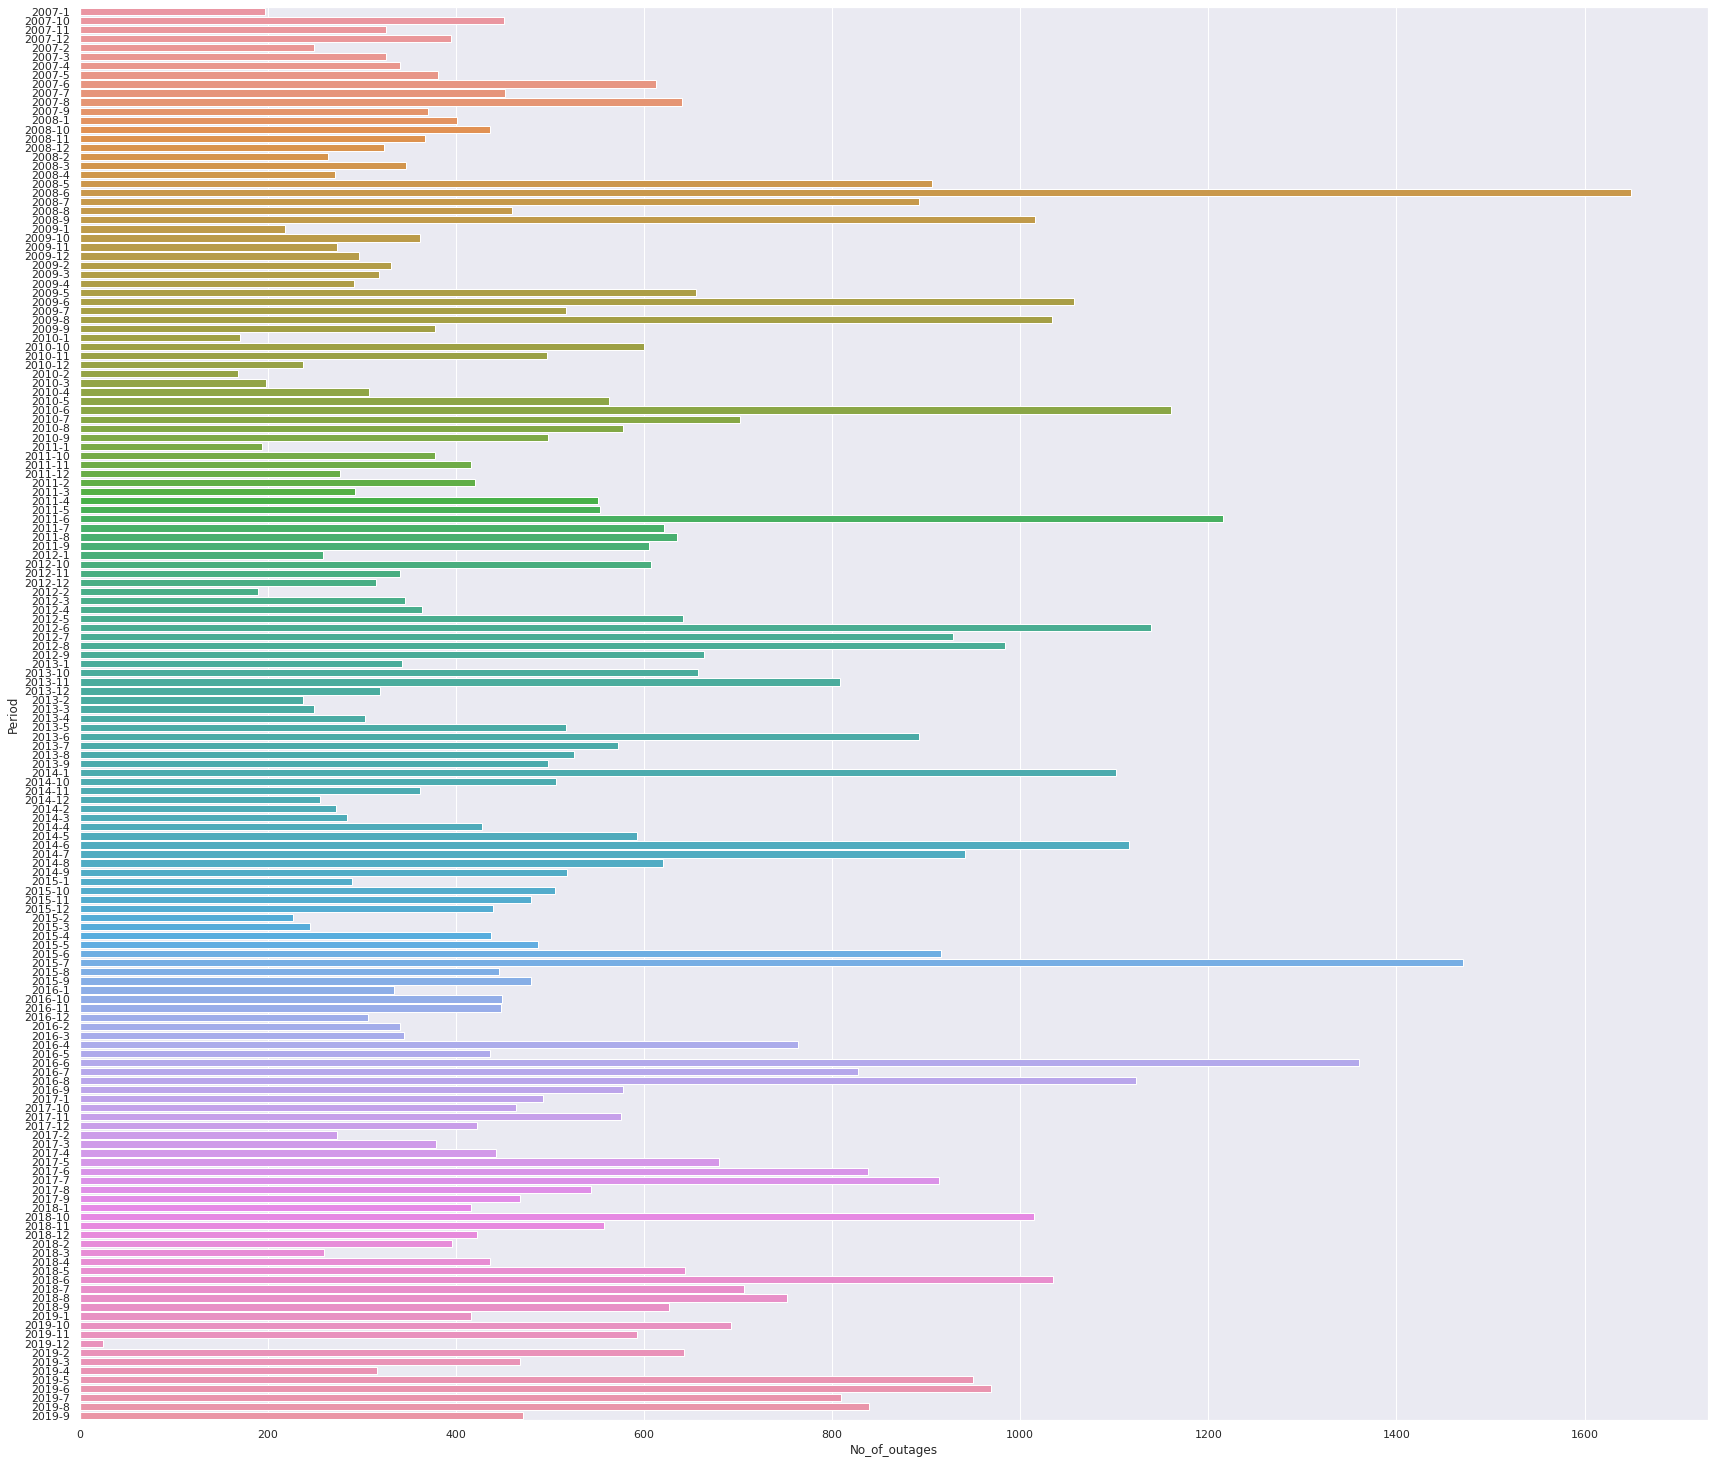

In [ ]:
sns.set(style="white")
sns.set(rc={'figure.figsize':(26,26)})
ax = sns.barplot(x="No_of_outages", y="Period", data=df_outages)

In [ ]:
df_outages['Year'] = df_outages.Period.apply(lambda x: '2019' if (x.lower().find('2019') != -1) else 0)

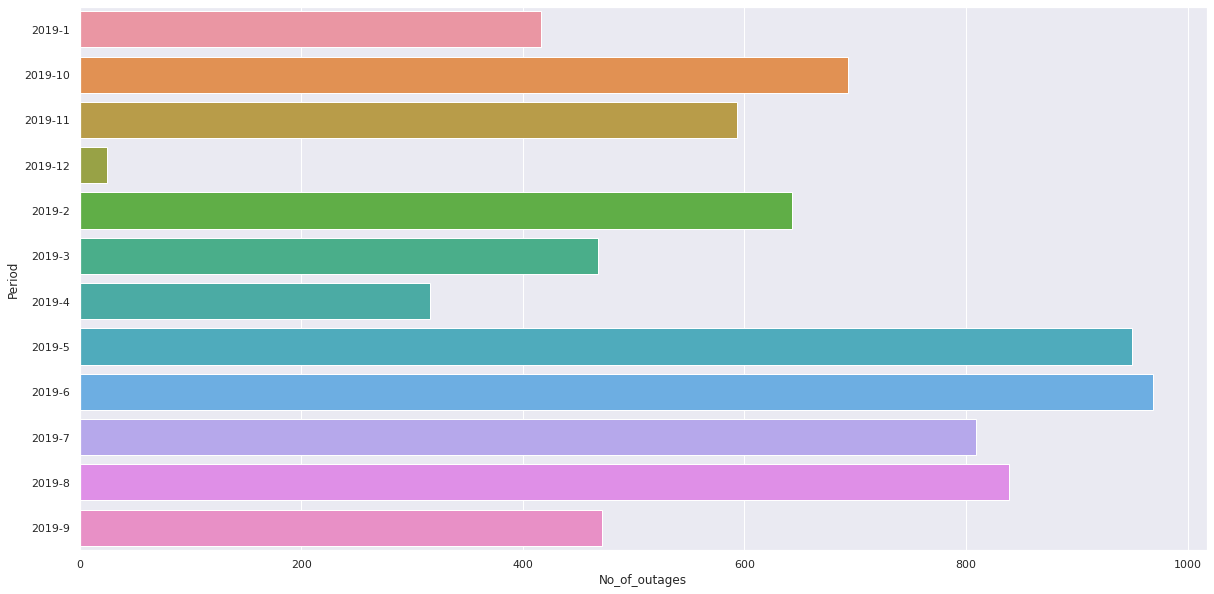

In [ ]:
sns.set(style="white")
sns.set(rc={'figure.figsize':(18,10)})
ax = sns.barplot(x="No_of_outages", y="Period", data=df_outages[df_outages['Year'] == '2019'])

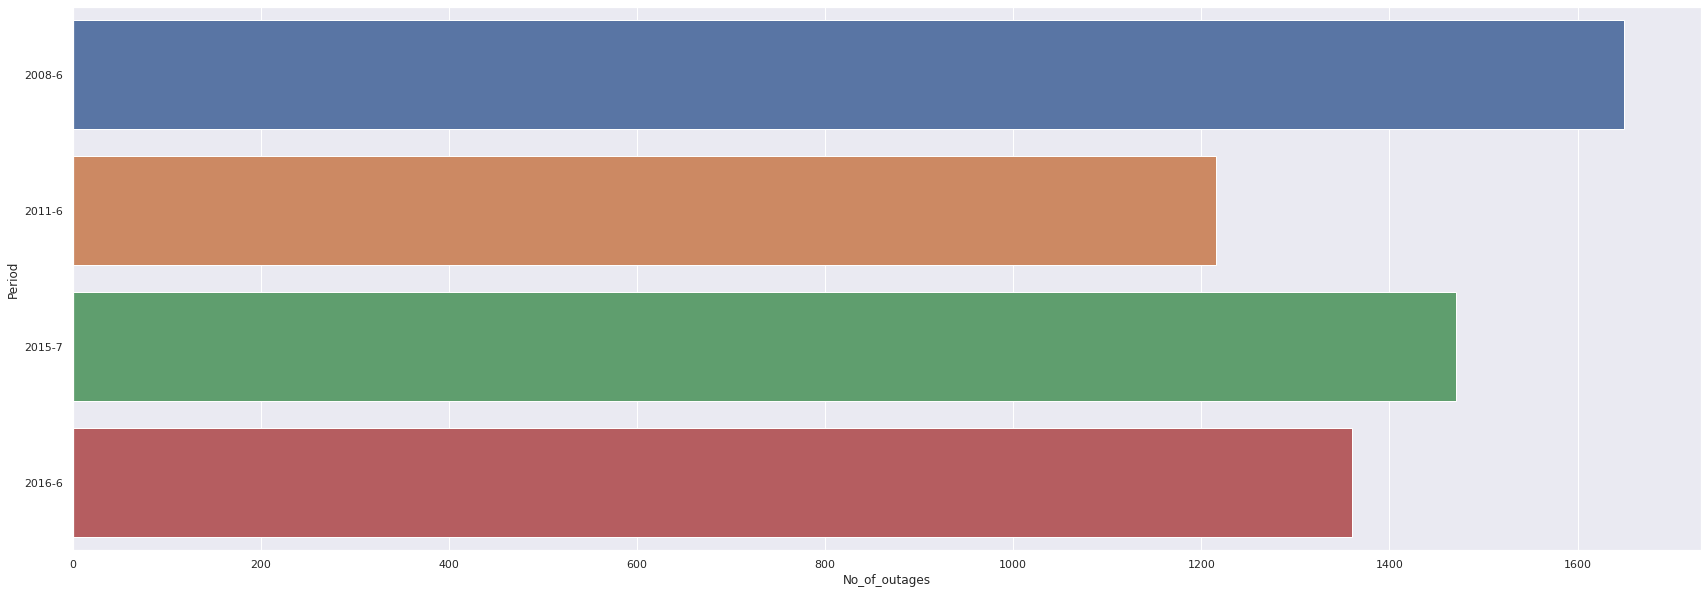

In [ ]:
sns.set(style="white")
sns.set(rc={'figure.figsize':(26,10)})
ax = sns.barplot(x="No_of_outages", y="Period", data=df_outages_v1)

**2008 - 06**
- The tornado outbreak sequence of May 22–31, 2008 was a series of tornado outbreaks affecting the central plains of the United States from May 22 to May 31 of 2008. <br>
- It was also one of the largest continuous tornado outbreaks on record. <br>
Link - https://www.weather.gov/ind/may302008_tor <br>

**2011 - 06**
-The tornado outbreak sequence of April 19–24, 2011 was an extended period of significant tornado activity that began on April 19th, 2011 and ended on April 24, 2011. 
Link - https://en.wikipedia.org/wiki/Tornado_outbreak_sequence_of_April_19%E2%80%9324,_2011

**2015 - 07**
- Waves of showers and thunderstorms moved across central Indiana on July 13 and into the early morning of July 14. <br>
- Upper level features interacted with a surface front and plenty of moisture and instability to generate severe weather and heavy rains/flooding. <br>
- Two tornadoes occurred during the evening of the 13th. One tornado was in Warren County, and the other was in Putnam County. <br>
- Widespread tree and power line damage occurred across central Indiana, and some locations received over 4 inches of rain. <br>
- A few locations had hail as well. <br>
- The heavy rain led to flooding in many areas. <br>
Link - https://www.weather.gov/ind/july13142015severe <br>

**2016 - 06**
- An upper level system worked with a hot and unstable atmosphere to produce strong to severe thunderstorms across central Indiana during the afternoon and early evening of June 15. <br>
- Damaging winds and heavy rain/flooding were the main impacts. <br>
Link - https://www.weather.gov/ind/june152016severe <br>

### **Outlier Detection**
In statistics, an outlier is an observation point that is distant from other observations.

### **Discovering outliers with visualization tools**
- In descriptive statistics, a box plot is a method for graphically depicting groups of numerical data through their quartiles. <br>
- Box plots may also have lines extending vertically from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. <br>
- Outliers may be plotted as individual points. <br>

Mean TTR 258.28
Median TTR 88.85


[]

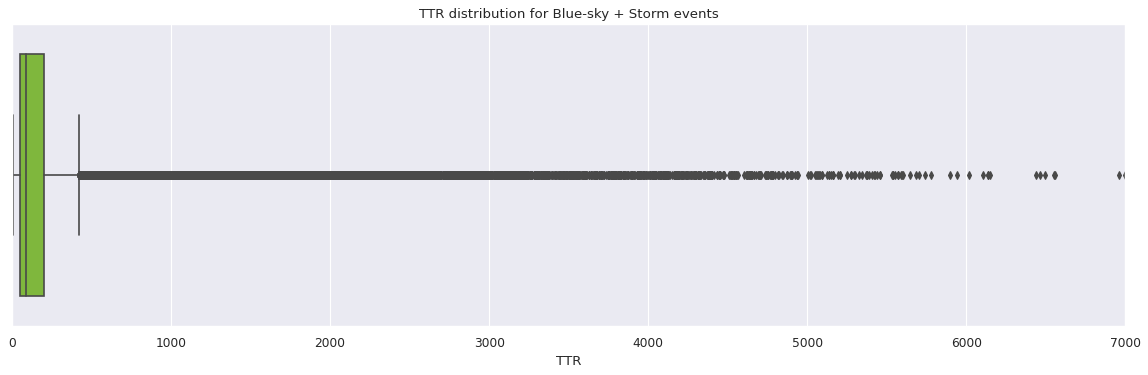

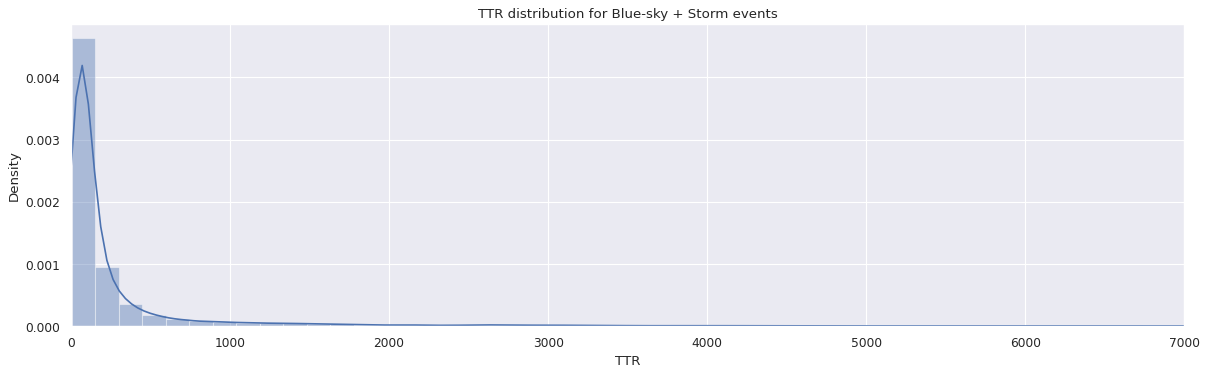

In [ ]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.boxplot(ads_df.TTR, palette = ['#81cb29'])
ax.set_title('TTR distribution for Blue-sky + Storm events')
ax.set(xlim=(0, 7000))
plt.plot()
print("Mean TTR", round(ads_df.TTR.mean(),2))
print("Median TTR", round(ads_df.TTR.median(),2))

plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.distplot(ads_df.TTR)
ax.set_title('TTR distribution for Blue-sky + Storm events')
ax.set(xlim=(0, 7000))
plt.plot()

In [ ]:
ads_df['Date'] = ads_df['CREATION_DATETIME'].dt.date
ads_df['Date'] = pd.to_datetime(ads_df['Date'])

In [ ]:
ads_df = ads_df[~((ads_df['Date'].dt.year == 2008) & (ads_df['Date'].dt.month == 6))]
ads_df = ads_df[~((ads_df['Date'].dt.year == 2011) & (ads_df['Date'].dt.month == 6))]
ads_df = ads_df[~((ads_df['Date'].dt.year == 2015) & (ads_df['Date'].dt.month == 7))]
ads_df = ads_df[~((ads_df['Date'].dt.year == 2016) & (ads_df['Date'].dt.month == 6))]

In [ ]:
print(ads_df.shape)
ads_df.head()

(78344, 160)


,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Marker_Location,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Live_outage_group,Priority_Customer_Qty,Dis_From_Live_Centriod_div_Cust_qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Active_no_of_trucks_per_day,Month,Year,Period,Date
0,2001309371,2000383861.00,3059,BLUE SKY,2007-01-01 03:33:00,2007-01-01 03:48:00,3059.00,SSUB,305.00,4,177.00,1.00,2007-01-01 05:03:00,177.00,False,15.00,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,39.88,-86.11,ZONE3,7,1,5,2,1,Marker4,0.71,0.71,1.00,0,0,0,0,0,0,0,0,0,0,0,Monday,False,1,1.00,0.00,1.00,ARL.,92.00,100.00,44.00,33.90,39.50,30.00,30.30,36.70,24.30,38.50,43.70,34.50,1016.40,1026.00,1008.90,0.00,28.50,125.40,684.30,83.30,90.30,79.30,986.80,995.80,980.10,0.00,4.20,5.20,3.60,38.50,43.70,34.50,36.60,41.70,32.80,30.30,36.70,24.30,269.00,269.00,267.00,16.80,20.30,8.80,17.00,20.60,8.90,14.40,17.80,6.70,9.20,11.10,15.70,56.00,11.00,1.14,1.02,nan,1,2007,2007-1,2007-01-01
1,2001309379,2000383864.00,494-B/403,BLUE SKY,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,True,108.17,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,39.78,-86.27,ZONE4,7,1,5,2,1,Marker10,0.87,-0.50,2.00,0,0,0,0,0,1,1,1,1,1,1,Monday,False,2,2.00,1.05,2.00,MILL,93.00,100.00,43.00,33.20,39.10,29.50,29.60,36

Mean TTR 236.72
Median TTR 86.35


[]

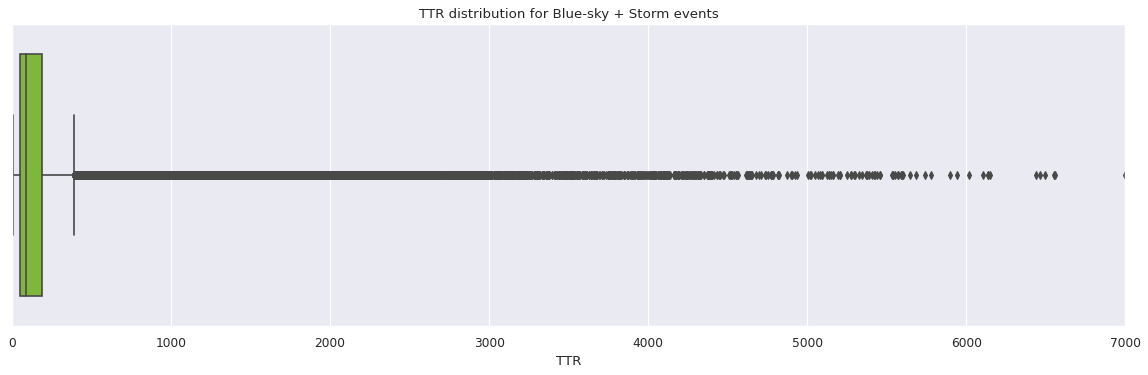

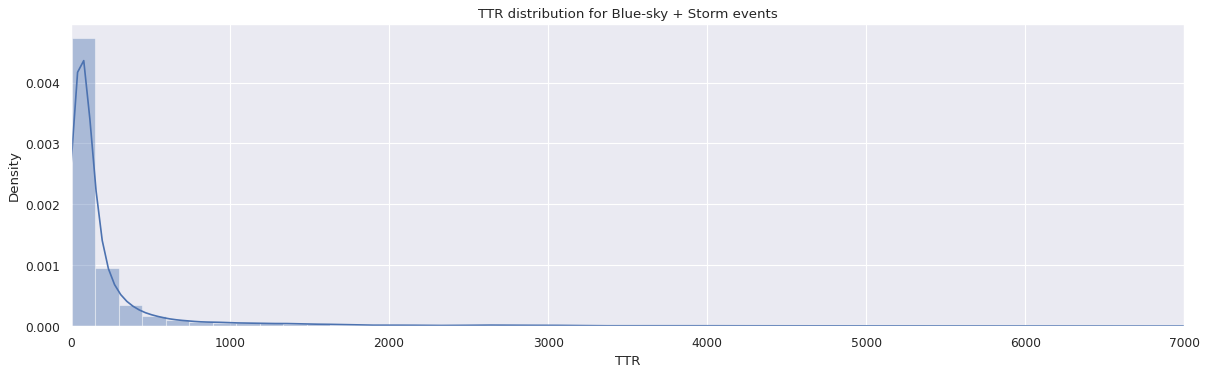

In [ ]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.boxplot(ads_df.TTR, palette = ['#81cb29'])
ax.set_title('TTR distribution for Blue-sky + Storm events')
ax.set(xlim=(0, 7000))
plt.plot()
print("Mean TTR", round(ads_df.TTR.mean(),2))
print("Median TTR", round(ads_df.TTR.median(),2))

plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.distplot(ads_df.TTR)
ax.set_title('TTR distribution for Blue-sky + Storm events')
ax.set(xlim=(0, 7000))
plt.plot()

### **IQR score**
- The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 95th and 5th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1. <br>
- In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data. <br>
- It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers. <br>

In [ ]:
q_low = ads_df["TTR"].quantile(0.01)
q_hi  = ads_df["TTR"].quantile(0.99)

df_ipl_ads_v1 = ads_df[(ads_df["TTR"] < q_hi) & (ads_df["TTR"] > q_low)]
print(ads_df.shape)
print(df_ipl_ads_v1.shape)

(78344, 160)
(76776, 160)


Mean TTR 204.25
Median TTR 86.35


[]

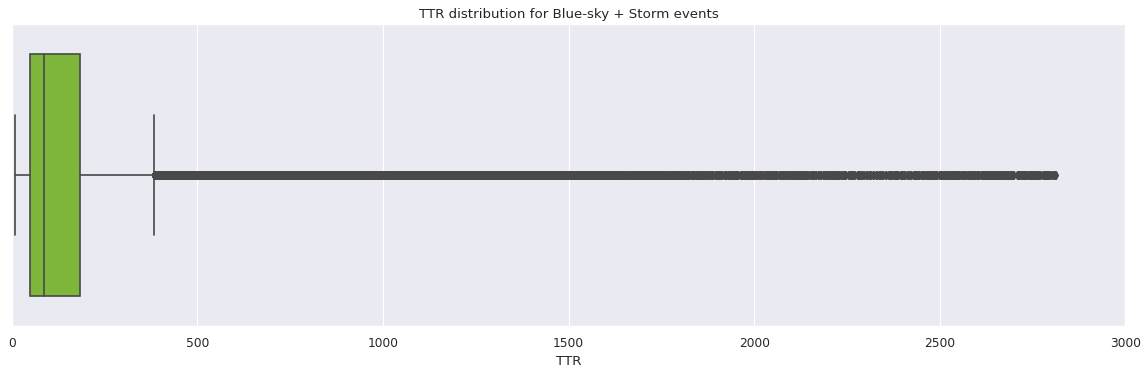

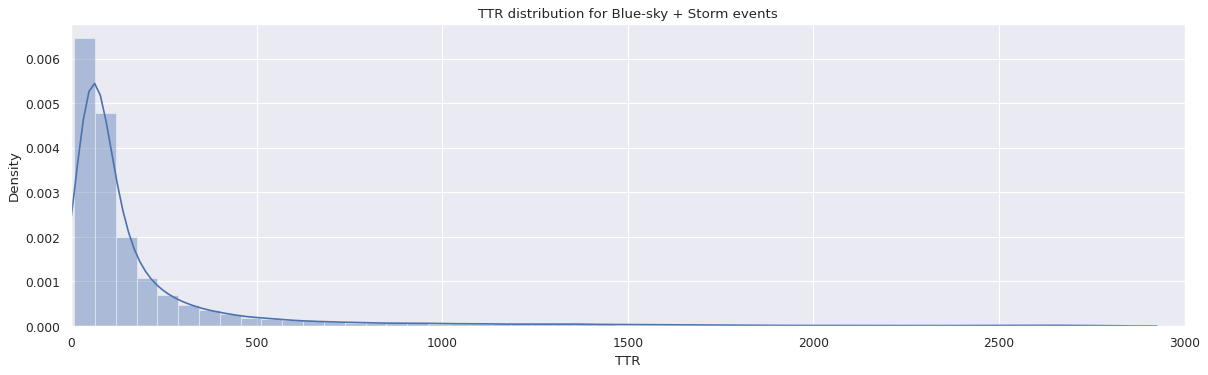

In [ ]:
plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.boxplot(df_ipl_ads_v1.TTR, palette = ['#81cb29'])
ax.set_title('TTR distribution for Blue-sky + Storm events')
ax.set(xlim=(0, 3000))
plt.plot()
print("Mean TTR", round(df_ipl_ads_v1.TTR.mean(),2))
print("Median TTR", round(df_ipl_ads_v1.TTR.median(),2))

plt.figure(num = None,figsize=(16, 5),dpi=80,facecolor='w',edgecolor='k')
ax = sns.distplot(df_ipl_ads_v1.TTR)
ax.set_title('TTR distribution for Blue-sky + Storm events')
ax.set(xlim=(0, 3000))
plt.plot()

In [135]:
df_ipl_ads_v1.reset_index(drop=True, inplace=True)
df_ipl_ads_v1.head()

,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Marker_Location,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Live_outage_group,Priority_Customer_Qty,Dis_From_Live_Centriod_div_Cust_qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Active_no_of_trucks_per_day,Month,Year,Period,Date
0,2001309371,2000383861.00,3059,BLUE SKY,2007-01-01 03:33:00,2007-01-01 03:48:00,3059.00,SSUB,305.00,4,177.00,1.00,2007-01-01 05:03:00,177.00,False,15.00,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,39.88,-86.11,ZONE3,7,1,5,2,1,Marker4,0.71,0.71,1.00,0,0,0,0,0,0,0,0,0,0,0,Monday,False,1,1.00,0.00,1.00,ARL.,92.00,100.00,44.00,33.90,39.50,30.00,30.30,36.70,24.30,38.50,43.70,34.50,1016.40,1026.00,1008.90,0.00,28.50,125.40,684.30,83.30,90.30,79.30,986.80,995.80,980.10,0.00,4.20,5.20,3.60,38.50,43.70,34.50,36.60,41.70,32.80,30.30,36.70,24.30,269.00,269.00,267.00,16.80,20.30,8.80,17.00,20.60,8.90,14.40,17.80,6.70,9.20,11.10,15.70,56.00,11.00,1.14,1.02,nan,1,2007,2007-1,2007-01-01
1,2001309379,2000383864.00,494-B/403,BLUE SKY,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,True,108.17,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,39.78,-86.27,ZONE4,7,1,5,2,1,Marker10,0.87,-0.50,2.00,0,0,0,0,0,1,1,1,1,1,1,Monday,False,2,2.00,1.05,2.00,MILL,93.00,100.00,43.00,33.20,39.10,29.50,29.60,36

In [150]:
df_ipl_ads_v1.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_V10.4_IQR_FULL.csv',index=False)

### **Drop columns which will not be used for modelling purpose**

In [ ]:
# df_ipl_ads_v1_storm = df_ipl_ads_v1.copy(deep=True)
# df_ipl_ads_v1_storm = df_ipl_ads_v1_storm[df_ipl_ads_v1_storm.EVENT=='STORM']

# ads_df_storm = ads_df.copy(deep=True)
# ads_df_storm = ads_df_storm[ads_df_storm.EVENT=='STORM']

In [147]:
df_ipl_ads_v1.drop(['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'ENERGIZED_DATETIME', 'CIRCT_ID', 'SUBST_ID', 
                    'ETR_DATETIME', 'CUST_QTY', 'LAT', 'LONG', 'LIVE_OUTAGE', 'Live_outage_group', 'Marker_Location', 'Dis_From_Live_Centriod_div_Cust_qty',
                    'Active_no_of_trucks_per_day', 'Month', 'Year', 'Period'], axis=1, inplace=True)

In [147]:
# split into train test sets
# OMS_IPL_OUTAGE_DATASET_V10_4_TRAIN_IQR, OMS_IPL_OUTAGE_DATASET_V10_4_VALIDATION_IQR = train_test_split(df_ipl_ads_v1, test_size=0.20, random_state=369)

In [148]:
# split into train test sets
# OMS_IPL_OUTAGE_DATASET_V10_4_TRAIN, OMS_IPL_OUTAGE_DATASET_V10_4_VALIDATION = train_test_split(ads_df, test_size=0.20, random_state=369)

In [150]:
print(df_ipl_ads_v1.shape)
# print(df_ipl_ads_v1_storm.shape)
# print('\n')
# print(ads_df.shape)
# print(ads_df_storm.shape)

(76776, 141)


In [148]:
print(list(df_ipl_ads_v1.columns))

['EVENT', 'CREATION_DATETIME', 'DNI_EQUIP_TYPE', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG'

## **WRITE TO CSV**

In [149]:
df_ipl_ads_v1.to_csv("gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_V10.4_IQR_09152020.csv",index=False)
# df_ipl_ads_v1_storm.to_csv("gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_V10.4_Storm_IQR_08092020.csv",index=False)

# ads_df.to_csv("gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_V10.4_MAJOR_STORMS_08092020.csv",index=False)
# ads_df_storm.to_csv("gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_V10.4_Storm_MAJOR_STORMS_08092020.csv",index=False)